# Final Project Notebook

DS 5001 Exploratory Text Analytics | Spring 2024

# Metadata

- Full Name: Will Sivolella
- Userid: WillSivolella
- GitHub Repo URL: https://github.com/WillSivolella/TextAnalyticsFinalProject
- UVA Box URL: https://virginia.box.com/s/4lppyxkn65ccm4393w3lcttnqztr3dqo

# Overview

The goal of the final project is for you to create a **digital analytical edition** of a corpus using the tools, practices, and perspectives you’ve learning in this course. You will select a corpus that has already been digitized and transcribed, parse that into an F-compliant set of tables, and then generate and visualize the results of a series of fitted models. You will also draw some tentative conclusions regarding the linguistic, cultural, psychological, or historical features represented by your corpus. The point of the exercise is to have you work with a corpus through the entire pipeline from ingestion to interpretation. 

Specifically, you will acquire a collection of long-form texts and perform the following operations:

- **Convert** the collection from their source formats (F0) into a set of tables that conform to the Standard Text Analytic Data Model (F2).
- **Annotate** these tables with statistical and linguistic features using NLP libraries such as NLTK (F3).
- **Produce** a vector representation of the corpus to generate TFIDF values to add to the TOKEN (aka CORPUS) and VOCAB tables (F4).
- **Model** the annotated and vectorized model with tables and features derived from the application of unsupervised methods, including PCA, LDA, and word2vec (F5).
- **Explore** your results using statistical and visual methods.
- **Present** conclusions about patterns observed in the corpus by means of these operations.

When you are finished, you will make the results of your work available in GitHub (for code) and UVA Box (for data). You will submit to Gradescope (via Canvas) a PDF version of a Jupyter notebook that contains the information listed below.

# Some Details

- Please fill out your answers in each task below by editing the markdown cell. 
- Replace text that asks you to insert something with the thing, i.e. replace `(INSERT IMAGE HERE)` with an image element, e.g. `![](image.png)`.
- For URLs, just paste the raw URL directly into the text area. Don't worry about providing link labels using `[label](link)`.
- Please do not alter the structure of the document or cell, i.e. the bulleted lists. 
- You may add explanatory paragraphs below the bulleted lists.
- Please name your tables as they are named in each task below.
- Tasks are indicated by headers with point values in parentheses.

# Raw Data

## Source Description (1)

Provide a brief description of your source material, including its provenance and content. Tell us where you found it and what kind of content it contains.

My source material is all 6 volumes of History of the Decline and Fall of the Roman Empire by Edward Gibbon. I retrieved these as text files from the Project Gutenburg website. I am specifically just using the chapter contents of each of the volumes and the corpus is split as so. I specifically chose this source because I am interested in the topic and I think the decline of the Roman Empire is extremely complicated as overtime it was split into multiple empires and provinces. The goal of this project is to shed light on similarities and differences between all the volumes by analyzing word choice, sentiment, ect... The awareness of the similarities and differences of the volumes will hopefully provide a story of the ups and downs of the long fall of the Roman Empire as the volumes are mostly in chronological order.

## Source Features (1)

Add values for the following items. (Do this for all following bulleted lists.)

- Source URL: https://www.gutenberg.org/ebooks/890, https://www.gutenberg.org/ebooks/891, https://www.gutenberg.org/ebooks/733, https://www.gutenberg.org/ebooks/734, https://www.gutenberg.org/ebooks/735, https://www.gutenberg.org/ebooks/736
- UVA Box URL: https://virginia.box.com/s/hkqih3sy3bww3f4cgyxz0oaj9i6c7e7b
- Number of raw documents:6 
- Total size of raw documents (e.g. in MB): 7.9 MB
- File format(s), e.g. XML, plaintext, etc.: .txt files

## Source Document Structure (1)

Provide a brief description of the internal structure of each document. That, describe the typical elements found in document and their relation to each other. For example, a corpus of letters might be described as having a date, an addressee, a salutation, a set of content paragraphs, and closing. If they are various structures, state that.

Each of the 6 volumes are in .txt file format and I specifically extracted the chapter contents and did not include any introductory or appendix information. The chapters continue in order volume-to-volume. For example, Volume 1 ends on chapter 47, and Volume 2 starts with chapter 48. Therefore, I structured the corpus to be indexed by book_id and then chap_id (chapter number).

# Parsed and Annotated Data

Parse the raw data into the three core tables of your addition: the `LIB`, `CORPUS`, and `VOCAB` tables.

These tables will be stored as CSV files with header rows.

You may consider using `|` as a delimitter.

Provide the following information for each.

### Initial Setup

In [202]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
import configparser
import nltk
from textparser import TextParser
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import norm, eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import word2vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE as tsne
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pwd

'C:\\Users\\wills\\OneDrive\\Documents\\TEXTANALYTICS'

In [3]:
config = configparser.ConfigParser()
config.read("env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [4]:
data_home, output_dir

('/Users/wills/OneDrive/Documents/TEXTANALYTICS/data',
 '/Users/wills/OneDrive/Documents/TEXTANALYTICS/output')

In [5]:
source_files = f"{data_home}/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set/"

In [6]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [7]:
source_file_list

['/Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\\History of the Decline and Fall of the Roman Empire-Volume 1 Edward Gibbon-pg890.txt',
 '/Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\\History of the Decline and Fall of the Roman Empire-Volume 2 Edward Gibbon-pg891.txt',
 '/Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\\History of the Decline and Fall of the Roman Empire-Volume 3 Edward Gibbon-pg892.txt',
 '/Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\\History of the Decline and Fall of the Roman Empire-Volume 4 Edward Gibbon-pg893.txt',
 '/Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\\History of the Decline and Fall of the Roman Empire-

In [8]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
chap_regex = r"(?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*\n|$)"

## LIB (2)

The source documents the corpus comprises. These may be books, plays, newspaper articles, abstracts, blog posts, etc. 

Note that these are *not* documents in the sense used to describe a bag-of-words representation of a text, e.g. chapter.

- UVA Box URL: https://virginia.box.com/s/p63iv1rogbby82aplbzxy4r0izjx5gfe
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ","
- Number of observations: 6 books
- List of features, including at least three that may be used for model summarization (e.g. date, author, etc.): source_file_path, author, title, chap_regex, num_characters
- Average length of each document in characters: 1327243.1666666667

In [9]:
book_data = []
for source_file_path in source_file_list:
    book_id = int(source_file_path.split('-')[-1].split('.')[0].replace('pg',''))
    book_title = source_file_path.split('\\')[-1].split('-pg')[0]
    book_data.append((book_id, source_file_path, book_title))

In [10]:
LIB = pd.DataFrame(book_data, columns=['book_id','source_file_path','raw_title'])\
 .set_index('book_id').sort_index()

In [11]:
try:
    # Extract the author by taking the last two words from the string
    LIB['author'] = LIB.raw_title.apply(lambda x: ' '.join(x.split()[-2:]))
    # Extract the title by taking all words except the last two
    LIB['title'] = LIB.raw_title.apply(lambda x: ' '.join(x.split()[:-2]))
    # Drop the original 'raw_title' column as it's no longer needed
    LIB = LIB.drop('raw_title', axis=1)
except AttributeError:
    # This will handle cases where 'raw_title' or any method used does not exist
    pass

In [12]:
LIB['chap_regex'] = chap_regex

In [13]:
LIB

source_file_path         author  \
book_id                                                                     
735      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
736      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
890      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
891      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
892      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
893      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   

                                                     title  \
book_id                                                      
735      History of the Decline and Fall of the Roman E...   
736      History of the Decline and Fall of the Roman E...   
890      History of the Decline and Fall of the Roman E...   
891      History of the Decline and Fall of the Roman E...   
892      History of the Decline and Fall of the Roman E...   
893      History of the Decline and Fall of the Roman E...   

                                                chap_regex  
book_id                                                     
735      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...  
736      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...  
890      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...  
891      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...  
892      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...  
893      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...

In [14]:
# Adding number of characters in each book to the library

def count_characters(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return len(file.read())
    except Exception as e:
        print(f"Failed to read {file_path}: {e}")
        return None  # Or appropriate error handling

LIB['num_characters'] = LIB['source_file_path'].apply(count_characters)

In [15]:
LIB

source_file_path         author  \
book_id                                                                     
735      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
736      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
890      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
891      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
892      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   
893      /Users/wills/OneDrive/Documents/TEXTANALYTICS/...  Edward Gibbon   

                                                     title  \
book_id                                                      
735      History of the Decline and Fall of the Roman E...   
736      History of the Decline and Fall of the Roman E...   
890      History of the Decline and Fall of the Roman E...   
891      History of the Decline and Fall of the Roman E...   
892      History of the Decline and Fall of the Roman E...   
893      History of the Decline and Fall of the Roman E...   

                                                chap_regex  num_characters  
book_id                                                                     
735      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...         1742820  
736      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...         1565621  
890      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...         1215757  
891      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...         1194526  
892      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...         1041137  
893      (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*...         1203598

In [156]:
avg_len = LIB['num_characters'].mean()
avg_len

1327243.1666666667

In [131]:
#cd C:\Users\wills\OneDrive\Documents\TEXTANALYTICS\FinalProjectFiles

In [132]:
#pwd

In [135]:
# Export the DataFrame to a CSV file
#LIB.to_csv('LIB.csv', index=True)

## CORPUS (2)

The sequence of word tokens in the corpus, indexed by their location in the corpus and document structures.

- UVA Box URL: https://virginia.box.com/s/3pacfjd5lgrrsb5hmx4awgsd92kkv333
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Number of observations Between (should be >= 500,000 and <= 2,000,000 observations.): 1,233,321 
- OHCO Structure (as delimitted column names): 'book_id', 'chap_num', 'para_num', 'sent_num', 'token_num'
- Columns (as delimitted column names, including `token_str`, `term_str`, `pos`, and `pos_group`): 'pos_tuple', 'pos', 'token_str', 'term_str', 'pos_group'

In [16]:
def tokenize_collection(LIB):
    clip_pats = [
     r"\*\*\*\s*START OF",
     r"\*\*\*\s*END OF"
     ]
    books = []
    for book_id in LIB.index:
        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)
         # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path
         # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)
         # Define parameters
        text.verbose = True
        text.strip_hyphens = True
        text.strip_whitespace = True
         # Pars
        text.import_source().parse_tokens();
         # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)
         # Add to list
        books.append(text.TOKENS)
 
         # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()
         # Clean up
    del(books)
    del(text)
 
    print("Done")
 
    return CORPUS 

In [17]:
CORPUS = tokenize_collection(LIB)

Tokenizing 735 History of the Decline and Fall of the Roman Empire-Volume 5
Importing  /Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\History of the Decline and Fall of the Roman Empire-Volume 5 Edward Gibbon-pg735.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*\n|$)
line_str chap_str
Index(['chap_str'], dtype='object')
Parsing OHCO level 1 para_num by delimitter \n\n
Parsing OHCO level 2 sent_num by NLTK model
Parsing OHCO level 3 token_num by NLTK model
Tokenizing 736 History of the Decline and Fall of the Roman Empire-Volume 6
Importing  /Users/wills/OneDrive/Documents/TEXTANALYTICS/data/gutenberg/History-of-the-Decline-and-Fall-of-the-Roman-Empire-set\History of the Decline and Fall of the Roman Empire-Volume 6 Edward Gibbon-pg736.txt
Clipping text
Parsing OHCO level 0 chap_id by milestone (?m)^\s*Chapter\s+[IVXLCDM]+[ \-:]+.*?(?=\n\s*\n|$)
line_str chap_

In [18]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                              
735     1       0        0        0          (Introduction,, NNP)  NNP   
                                  1               (Worship,, NNP)  NNP   
                                  2                     (And, CC)   CC   
                                  3            (Persecution, NNP)  NNP   
                                  4                      (Of, IN)   IN   
...                                                           ...  ...   
893     48      8        0        50            (Alexander., NNP)  NNP   
                9        0        0                     (End, NN)   NN   
                                  1                      (Of, IN)   IN   
                                  2                   (Vol., NNP)  NNP   
                         1        0                     (IV., NN)   NN   

                                                 token_str      term_str  
book_id chap_id para_num sent_num token_num                               
735     1       0        0        0          Introduction,  introduction  
                                  1               Worship,       worship  
                                  2                    And           and  
                                  3            Persecution   persecution  
                                  4                     Of            of  
...                                                    ...           ...  
893     48      8        0        50            Alexander.     alexander  
                9        0        0                    End           end  
                                  1                     Of            of  
                                  2                   Vol.           vol  
                         1        0                    IV.            iv  

[1236326 rows x 4 columns]

In [19]:
CORPUS.reset_index()[['book_id','chap_id']]\
 .drop_duplicates()\
 .groupby('book_id').chap_id.count()

book_id
735    48
736    42
890    52
891    59
892    48
893    48
Name: chap_id, dtype: int64

In [20]:
CORPUS[CORPUS.term_str == '']

pos_tuple  pos token_str term_str
book_id chap_id para_num sent_num token_num                                  
735     1       2        0        2          ([, PDT)  PDT         [         
                4        0        2          ([, NNP)  NNP         [         
                5        0        2          ([, NNP)  NNP         [         
                6        0        2          ([, NNP)  NNP         [         
                7        0        2          ([, NNP)  NNP         [         
...                                               ...  ...       ...      ...
893     21      6        4        0           (*, IN)   IN         *         
        24      3        25       0           (*, VB)   VB         *         
        27      7        11       0           (*, NN)   NN         *         
        28      0        8        13          (*, NN)   NN         *         
        37      6        3        0           (*, NN)   NN         *         

[3005 rows x 4 columns]

In [21]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

token_str
[         2594
*          357
”           11
;)          11
]            7
....         7
—            5
&            2
**           2
.....        2
:)           1
]?           1
————         1
—————,       1
......       1
___          1
­            1
Name: count, dtype: int64

In [22]:
CORPUS = CORPUS[CORPUS.term_str != '']

In [23]:
CORPUS['pos_group'] = CORPUS.pos.str[:2]

C:\Users\wills\AppData\Local\Temp\ipykernel_5268\236658476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CORPUS['pos_group'] = CORPUS.pos.str[:2]


In [24]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                              
735     1       0        0        0          (Introduction,, NNP)  NNP   
                                  1               (Worship,, NNP)  NNP   
                                  2                     (And, CC)   CC   
                                  3            (Persecution, NNP)  NNP   
                                  4                      (Of, IN)   IN   
...                                                           ...  ...   
893     48      8        0        50            (Alexander., NNP)  NNP   
                9        0        0                     (End, NN)   NN   
                                  1                      (Of, IN)   IN   
                                  2                   (Vol., NNP)  NNP   
                         1        0                     (IV., NN)   NN   

                                                 token_str      term_str  \
book_id chap_id para_num sent_num token_num                                
735     1       0        0        0          Introduction,  introduction   
                                  1               Worship,       worship   
                                  2                    And           and   
                                  3            Persecution   persecution   
                                  4                     Of            of   
...                                                    ...           ...   
893     48      8        0        50            Alexander.     alexander   
                9        0        0                    End           end   
                                  1                     Of            of   
                                  2                   Vol.           vol   
                         1        0                    IV.            iv   

                                            pos_group  
book_id chap_id para_num sent_num token_num            
735     1       0        0        0                NN  
                                  1                NN  
                                  2                CC  
                                  3                NN  
                                  4                IN  
...                                               ...  
893     48      8        0        50               NN  
                9        0        0                NN  
                                  1                IN  
                                  2                NN  
                         1        0                NN  

[1233321 rows x 5 columns]

In [137]:
#CORPUS.to_csv('CORPUS.csv', index=True)

## VOCAB (2)

The unique word types (terms) in the corpus.

- UVA Box URL: https://virginia.box.com/s/24sj6ygj7kg5ztbxthnpa9lvio4sx2n7
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Number of observations: 33167
- Columns (as delimitted names, including `n`, `p`', `i`, `dfidf`, `porter_stem`, `max_pos` and `max_pos_group`, `stop`): 'n', 'n_chars', 'p', 'i'
- Note: Your VOCAB may contain ngrams. If so, add a feature for `ngram_length`.
- List the top 20 significant words in the corpus by DFIDF.

Top 20 word list: 
'haughty', 'attention', 'indulged', 'saved', 'jealousy', 'property',
'hour', 'writers', 'martial', 'best', 'sent', 'bishops', 'reigned',
'supreme', 'train', 'party', 'remains', 'heaven', 'remained','deserted'

In [25]:
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

In [26]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

In [27]:
VOCAB

n  n_chars             p          i
term_str                                        
069          1        3  8.109353e-07  20.233910
1          207        1  1.678636e-04  12.540423
10          98        2  7.947166e-05  13.619200
100         41        3  3.324835e-05  14.876358
1000         6        4  4.865612e-06  17.648947
...        ...      ...           ...        ...
κωμόπολις    1        9  8.109353e-07  20.233910
πλῆθος       1        6  8.109353e-07  20.233910
ριξ          1        3  8.109353e-07  20.233910
ἀπὸ          1        3  8.109353e-07  20.233910
ἰμπεράτορ    1        9  8.109353e-07  20.233910

[33167 rows x 4 columns]

In [28]:
max_pos = CORPUS.groupby('term_str')['pos'].agg(lambda x: x.mode()[0])
max_pos_group = CORPUS.groupby('term_str')['pos_group'].agg(lambda x: x.mode()[0])
VOCAB = VOCAB.join(max_pos.rename('max_pos'))
VOCAB = VOCAB.join(max_pos_group.rename('max_pos_group'))

In [29]:
VOCAB['porter_stem'] = VOCAB.index.map(porter.stem)
VOCAB['stop'] = VOCAB.index.map(lambda x: 1 if x in stop_words else 0)

In [30]:
VOCAB

n  n_chars             p          i max_pos max_pos_group  \
term_str                                                                 
069          1        3  8.109353e-07  20.233910      CD            CD   
1          207        1  1.678636e-04  12.540423      CD            CD   
10          98        2  7.947166e-05  13.619200      CD            CD   
100         41        3  3.324835e-05  14.876358      CD            CD   
1000         6        4  4.865612e-06  17.648947      CD            CD   
...        ...      ...           ...        ...     ...           ...   
κωμόπολις    1        9  8.109353e-07  20.233910     NNP            NN   
πλῆθος       1        6  8.109353e-07  20.233910      NN            NN   
ριξ          1        3  8.109353e-07  20.233910      JJ            JJ   
ἀπὸ          1        3  8.109353e-07  20.233910     NNP            NN   
ἰμπεράτορ    1        9  8.109353e-07  20.233910      NN            NN   

          porter_stem  stop  
term_str                     
069               069     0  
1                   1     0  
10                 10     0  
100               100     0  
1000             1000     0  
...               ...   ...  
κωμόπολις   κωμόπολις     0  
πλῆθος         πλῆθος     0  
ριξ               ριξ     0  
ἀπὸ               ἀπὸ     0  
ἰμπεράτορ   ἰμπεράτορ     0  

[33167 rows x 8 columns]

In [31]:
def new_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

In [32]:
def calculate_TF(DTCM, method):
    if method == 'sum':
        return DTCM.div(DTCM.sum(axis=1), axis=0)
    elif method == 'max':
        return DTCM.div(DTCM.max(axis=1), axis=0)
    elif method == 'log':
        return np.log2(1 + DTCM)
    elif method == 'raw':
        return DTCM
    elif method == 'bool':
        return DTCM.astype(bool).astype(int)
    else:
        raise ValueError(f"TF method {method} not found.")

def calculate_IDF(DTCM, N_docs, method):
    DF = DTCM.astype(bool).sum()
    if method == 'standard':
        return np.log2(N_docs / DF)
    elif method == 'textbook':
        return np.log2(N_docs / (DF + 1))
    elif method == 'sklearn':
        return np.log2(N_docs / DF) + 1
    elif method == 'sklearn_smooth':
        return np.log2((N_docs + 1) / (DF + 1)) + 1
    else:
        raise ValueError(f"DF method {method} not found.")

def get_TFIDF_DFIDF(BOW, tf_method='max', df_method='standard', item_type='term_str'):
    DTCM = BOW.n.unstack(fill_value=0)
    N_docs = len(DTCM)
    
    # Calculate TFIDF as before
    TF = calculate_TF(DTCM, tf_method)
    IDF = calculate_IDF(DTCM, N_docs, df_method)
    TFIDF = TF.multiply(IDF, axis=1)

    # Calculate DFIDF
    DF = DTCM.astype(bool).sum(axis=0).to_frame('DF')  
    DFIDF = DF.multiply(IDF, axis=0)  
    
    return TFIDF, DFIDF

In [33]:
bag_input = ['book_id', 'chap_id']

In [34]:
BOW = new_bow(CORPUS, bag=bag_input)

In [35]:
TFIDF, DFIDF = get_TFIDF_DFIDF(BOW, tf_method='max', df_method='standard', item_type='term_str')

In [36]:
VOCAB['dfidf'] = DFIDF

In [37]:
VOCAB

n  n_chars             p          i max_pos max_pos_group  \
term_str                                                                 
069          1        3  8.109353e-07  20.233910      CD            CD   
1          207        1  1.678636e-04  12.540423      CD            CD   
10          98        2  7.947166e-05  13.619200      CD            CD   
100         41        3  3.324835e-05  14.876358      CD            CD   
1000         6        4  4.865612e-06  17.648947      CD            CD   
...        ...      ...           ...        ...     ...           ...   
κωμόπολις    1        9  8.109353e-07  20.233910     NNP            NN   
πλῆθος       1        6  8.109353e-07  20.233910      NN            NN   
ριξ          1        3  8.109353e-07  20.233910      JJ            JJ   
ἀπὸ          1        3  8.109353e-07  20.233910     NNP            NN   
ἰμπεράτορ    1        9  8.109353e-07  20.233910      NN            NN   

          porter_stem  stop       dfidf  
term_str                                 
069               069     0    8.214319  
1                   1     0  154.734126  
10                 10     0  125.007323  
100               100     0   80.262036  
1000             1000     0   33.776140  
...               ...   ...         ...  
κωμόπολις   κωμόπολις     0    8.214319  
πλῆθος         πλῆθος     0    8.214319  
ριξ               ριξ     0    8.214319  
ἀπὸ               ἀπὸ     0    8.214319  
ἰμπεράτορ   ἰμπεράτορ     0    8.214319  

[33167 rows x 9 columns]

In [139]:
#VOCAB.to_csv('VOCAB.csv', index=True)

In [38]:
DFIDF

DF
term_str             
069          8.214319
1          154.734126
10         125.007323
100         80.262036
1000        33.776140
...               ...
κωμόπολις    8.214319
πλῆθος       8.214319
ριξ          8.214319
ἀπὸ          8.214319
ἰμπεράτορ    8.214319

[33167 rows x 1 columns]

### Top 20 significant words by DFIDF

In [39]:
sorted_df = DFIDF.sort_values(by='DF', ascending=False)
top_20_terms = sorted_df.head(20)

In [40]:
top_20_terms

DF
term_str             
haughty    157.628693
attention  157.628693
indulged   157.628693
saved      157.628693
jealousy   157.628693
property   157.628693
hour       157.628693
writers    157.628693
martial    157.628693
best       157.628693
sent       157.628693
bishops    157.628693
reigned    157.628693
supreme    157.628693
train      157.628693
party      157.628693
remains    157.625535
heaven     157.625535
remained   157.625535
deserted   157.625535

# Derived Tables

## BOW (3)

A bag-of-words representation of the CORPUS.

- UVA Box URL: https://virginia.box.com/s/mojfptzs9chiss4pt9tb723csogjjgsd
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Bag (expressed in terms of OHCO levels): ['book_id', 'chap_id']
- Number of observations: 426808 
- Columns (as delimitted names, including `n`, `tfidf`): 'n', 'tfidf'

In [41]:
BOW

n
book_id chap_id term_str   
735     1       1         7
                10        3
                1025      1
                1030      1
                104       1
...                      ..
893     48      younger   2
                your      1
                youth     4
                zeal      2
                zemlin    1

[426808 rows x 1 columns]

In [42]:
BOW['tfidf'] = TFIDF.stack()

In [43]:
BOW

n     tfidf
book_id chap_id term_str             
735     1       1         7  0.016336
                10        3  0.010710
                1025      1  0.011026
                1030      1  0.011026
                104       1  0.004954
...                      ..       ...
893     48      younger   2  0.005689
                your      1  0.002313
                youth     4  0.003394
                zeal      2  0.001676
                zemlin    1  0.010336

[426808 rows x 2 columns]

In [141]:
#BOW.to_csv('BOW.csv', index=True)

## DTM (3)

A represenation of the BOW as a sparse count matrix.

- UVA Box URL: https://virginia.box.com/s/tct3f38zdt7pb9tpu3bgnfych1y1uio1
- UVA Box URL of BOW used to generate (if applicable): https://virginia.box.com/s/mojfptzs9chiss4pt9tb723csogjjgsd
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Bag (expressed in terms of OHCO levels): 'book_id', 'chap_id'

In [44]:
DTM = BOW.reset_index().pivot_table(index=bag_input, columns='term_str', values='n', fill_value=0)

In [45]:
DTM

term_str         069  1  10  100  1000  10000  100000  1000000  10021013  \
book_id chap_id                                                            
735     1          0  7   3    0     0      0       0        0         0   
        2          0  0   0    0     0      0       0        0         0   
        3          0  2   1    0     0      0       0        0         0   
        4          0  4   0    3     0      0       0        0         0   
        5          0  0   1    0     0      0       0        0         0   
...              ... ..  ..  ...   ...    ...     ...      ...       ...   
893     44         0  0   0    0     0      0       0        0         0   
        45         0  0   0    0     0      0       0        0         0   
        46         0  0   0    0     0      0       0        0         0   
        47         0  0   0    0     0      0       0        0         0   
        48         0  0   0    0     0      0       0        0         0   

term_str         1005  ...  êra  êther  ëstablishment  βασιλεὺς  θύλης  \
book_id chap_id        ...                                               
735     1           0  ...    0      0              0         0      0   
        2           0  ...    0      0              0         0      0   
        3           0  ...    0      0              0         0      0   
        4           0  ...    0      0              0         0      0   
        5           0  ...    0      0              0         0      0   
...               ...  ...  ...    ...            ...       ...    ...   
893     44          0  ...    1      0              0         0      0   
        45          0  ...    0      0              0         0      0   
        46          0  ...    0      0              0         0      0   
        47          0  ...    0      0              0         0      0   
        48          0  ...    0      0              0         0      0   

term_str         κωμόπολις  πλῆθος  ριξ  ἀπὸ  ἰμπεράτορ  
book_id chap_id                                          
735     1                0       0    0    0          0  
        2                0       0    0    0          0  
        3                0       0    0    0          0  
        4                0       0    0    0          0  
        5                0       0    0    0          0  
...                    ...     ...  ...  ...        ...  
893     44               0       0    0    0          0  
        45               0       0    0    0          0  
        46               0       0    0    0          0  
        47               0       0    0    0          0  
        48               0       0    0    0          0  

[297 rows x 33167 columns]

In [143]:
#DTM.to_csv('DTM.csv', index=True)

## TFIDF (3)

A Document-Term matrix with TFIDF values.

- UVA Box URL: https://virginia.box.com/s/1mhsl0w8eo32wrwgxaqfpvgec3177ttt
- UVA Box URL of DTM or BOW used to create: https://virginia.box.com/s/mojfptzs9chiss4pt9tb723csogjjgsd
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Description of TFIDIF formula ($\LaTeX$ OK): 
Initially, the DTCM is derived from a BOW format. The TF is then calculated using various normalization methods—sum, max, logarithmic, raw, or binary—depending on the specified approach. Following this, the IDF is computed with several formula options, including standard, textbook adjustment to prevent division by zero, and variants adding smoothing factors, commonly used in scikit-learn implementations. Finally, the TF and IDF values are multiplied element-wise to produce the TF-IDF matrix, which quantifies the importance of each term in the corpus while considering its frequency across all documents. This methodological approach allows flexibility in handling different scaling and normalization strategies for text analysis.

In [46]:
TFIDF

term_str         069         1        10       100  1000  10000  100000  \
book_id chap_id                                                           
735     1        0.0  0.016336  0.010710  0.000000   0.0    0.0     0.0   
        2        0.0  0.000000  0.000000  0.000000   0.0    0.0     0.0   
        3        0.0  0.005528  0.004229  0.000000   0.0    0.0     0.0   
        4        0.0  0.012621  0.000000  0.020809   0.0    0.0     0.0   
        5        0.0  0.000000  0.004092  0.000000   0.0    0.0     0.0   
...              ...       ...       ...       ...   ...    ...     ...   
893     44       0.0  0.000000  0.000000  0.000000   0.0    0.0     0.0   
        45       0.0  0.000000  0.000000  0.000000   0.0    0.0     0.0   
        46       0.0  0.000000  0.000000  0.000000   0.0    0.0     0.0   
        47       0.0  0.000000  0.000000  0.000000   0.0    0.0     0.0   
        48       0.0  0.000000  0.000000  0.000000   0.0    0.0     0.0   

term_str         1000000  10021013  1005  ...       êra  êther  ëstablishment  \
book_id chap_id                           ...                                   
735     1            0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        2            0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        3            0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        4            0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        5            0.0       0.0   0.0  ...  0.000000    0.0            0.0   
...                  ...       ...   ...  ...       ...    ...            ...   
893     44           0.0       0.0   0.0  ...  0.007161    0.0            0.0   
        45           0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        46           0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        47           0.0       0.0   0.0  ...  0.000000    0.0            0.0   
        48           0.0       0.0   0.0  ...  0.000000    0.0            0.0   

term_str         βασιλεὺς  θύλης  κωμόπολις  πλῆθος  ριξ  ἀπὸ  ἰμπεράτορ  
book_id chap_id                                                           
735     1             0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        2             0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        3             0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        4             0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        5             0.0    0.0        0.0     0.0  0.0  0.0        0.0  
...                   ...    ...        ...     ...  ...  ...        ...  
893     44            0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        45            0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        46            0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        47            0.0    0.0        0.0     0.0  0.0  0.0        0.0  
        48            0.0    0.0        0.0     0.0  0.0  0.0        0.0  

[297 rows x 33167 columns]

In [145]:
#TFIDF.to_csv('TFIDF.csv', index=True)

## Reduced and Normalized TFIDF_L2 (3)

A Document-Term matrix with L2 normalized TFIDF values.

- UVA Box URL: https://virginia.box.com/s/7xq7zpynr05tbrj0ppyuppizbzjtdbzs
- UVA Box URL of source TFIDF table: https://virginia.box.com/s/1mhsl0w8eo32wrwgxaqfpvgec3177ttt
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Number of features (i.e. significant words): 1,000
- Principle of significant word selection: I did not filter by specific parts of speech

In [191]:
#Reducing size of TFIDF to include top 1,000 most significant terms by book and chapter

small_TFIDF = TFIDF.loc[:, VOCAB.join(DFIDF).sort_values('DF', ascending=False)\
 .head(1000).reset_index()['term_str'].to_list()].reset_index().groupby(['book_id', 'chap_id']).mean()

In [48]:
small_TFIDF

term_str          haughty  attention  indulged     saved  jealousy  property  \
book_id chap_id                                                                
735     1        0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
        2        0.002414   0.000000  0.002414  0.004828  0.000000  0.002414   
        3        0.000000   0.002299  0.002299  0.000000  0.002299  0.000000   
        4        0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
        5        0.000000   0.000000  0.000000  0.002225  0.000000  0.000000   
...                   ...        ...       ...       ...       ...       ...   
893     44       0.000000   0.000000  0.000000  0.002178  0.004356  0.002178   
        45       0.002075   0.000000  0.002075  0.000000  0.004150  0.000000   
        46       0.000000   0.002218  0.002218  0.000000  0.002218  0.006654   
        47       0.000000   0.000000  0.000000  0.000000  0.005605  0.000000   
        48       0.002072   0.000000  0.000000  0.002072  0.000000  0.000000   

term_str             hour   writers   martial      best  ...     noble  \
book_id chap_id                                          ...             
735     1        0.001941  0.001941  0.001941  0.000000  ...  0.001349   
        2        0.000000  0.000000  0.000000  0.000000  ...  0.001678   
        3        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        4        0.000000  0.005249  0.000000  0.002625  ...  0.001824   
        5        0.002225  0.004450  0.000000  0.000000  ...  0.001546   
...                   ...       ...       ...       ...  ...       ...   
893     44       0.002178  0.000000  0.000000  0.000000  ...  0.000000   
        45       0.006224  0.002075  0.000000  0.002075  ...  0.001442   
        46       0.006654  0.000000  0.000000  0.000000  ...  0.000000   
        47       0.000000  0.000000  0.001868  0.001868  ...  0.007790   
        48       0.004144  0.000000  0.006215  0.002072  ...  0.001440   

term_str          obscure     earth   station     birth       end       god  \
book_id chap_id                                                               
735     1        0.000000  0.001349  0.001349  0.000000  0.002698  0.006744   
        2        0.000000  0.003355  0.000000  0.000000  0.000000  0.006710   
        3        0.000000  0.003195  0.000000  0.001598  0.003195  0.000000   
        4        0.000000  0.000000  0.000000  0.000000  0.000000  0.001824   
        5        0.000000  0.001546  0.000000  0.000000  0.003092  0.001546   
...                   ...       ...       ...       ...       ...       ...   
893     44       0.001513  0.001513  0.000000  0.007567  0.000000  0.001513   
        45       0.001442  0.001442  0.000000  0.007209  0.000000  0.001442   
        46       0.001541  0.000000  0.001541  0.010788  0.000000  0.001541   
        47       0.002597  0.000000  0.001298  0.003895  0.002597  0.001298   
        48       0.001440  0.001440  0.002879  0.002879  0.002879  0.000000   

term_str         singular   priests    whence  
book_id chap_id                                
735     1        0.001349  0.000000  0.002691  
        2        0.000000  0.000000  0.000000  
        3        0.000000  0.003187  0.000000  
        4        0.001824  0.000000  0.000000  
        5        0.000000  0.000000  0.000000  
...                   ...       ...       ...  
893     44       0.000000  0.003019  0.000000  
        45       0.001442  0.002876  0.000000  
        46       0.001541  0.000000  0.003075  
        47       0.002597  0.000000  0.000000  
        48       0.004319  0.000000  0.005745  

[297 rows x 1000 columns]

In [49]:
TFIDF_L2 = small_TFIDF.apply(lambda x: x / np.linalg.norm(x), 1) # Pythagorean, AKA Euclidean

In [50]:
TFIDF_L2

term_str          haughty  attention  indulged     saved  jealousy  property  \
book_id chap_id                                                                
735     1        0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
        2        0.016132   0.000000  0.016132  0.032265  0.000000  0.016132   
        3        0.000000   0.011937  0.011937  0.000000  0.011937  0.000000   
        4        0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
        5        0.000000   0.000000  0.000000  0.012268  0.000000  0.000000   
...                   ...        ...       ...       ...       ...       ...   
893     44       0.000000   0.000000  0.000000  0.026826  0.053652  0.026826   
        45       0.021982   0.000000  0.021982  0.000000  0.043963  0.000000   
        46       0.000000   0.026230  0.026230  0.000000  0.026230  0.078689   
        47       0.000000   0.000000  0.000000  0.000000  0.065896  0.000000   
        48       0.022996   0.000000  0.000000  0.022996  0.000000  0.000000   

term_str             hour   writers   martial      best  ...     noble  \
book_id chap_id                                          ...             
735     1        0.008425  0.008425  0.008425  0.000000  ...  0.005854   
        2        0.000000  0.000000  0.000000  0.000000  ...  0.011210   
        3        0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        4        0.000000  0.023446  0.000000  0.011723  ...  0.008146   
        5        0.012268  0.024536  0.000000  0.000000  ...  0.008524   
...                   ...       ...       ...       ...  ...       ...   
893     44       0.026826  0.000000  0.000000  0.000000  ...  0.000000   
        45       0.065945  0.021982  0.000000  0.021982  ...  0.015274   
        46       0.078689  0.000000  0.000000  0.000000  ...  0.000000   
        47       0.000000  0.000000  0.021965  0.021965  ...  0.091578   
        48       0.045992  0.000000  0.068987  0.022996  ...  0.015979   

term_str          obscure     earth   station     birth       end       god  \
book_id chap_id                                                               
735     1        0.000000  0.005854  0.005854  0.000000  0.011709  0.029271   
        2        0.000000  0.022420  0.000000  0.000000  0.000000  0.044839   
        3        0.000000  0.016589  0.000000  0.008294  0.016589  0.000000   
        4        0.000000  0.000000  0.000000  0.000000  0.000000  0.008146   
        5        0.000000  0.008524  0.000000  0.000000  0.017049  0.008524   
...                   ...       ...       ...       ...       ...       ...   
893     44       0.018640  0.018640  0.000000  0.093201  0.000000  0.018640   
        45       0.015274  0.015274  0.000000  0.076371  0.000000  0.015274   
        46       0.018226  0.000000  0.018226  0.127582  0.000000  0.018226   
        47       0.030526  0.000000  0.015263  0.045789  0.030526  0.015263   
        48       0.015979  0.015979  0.031958  0.031958  0.031958  0.000000   

term_str         singular   priests    whence  
book_id chap_id                                
735     1        0.005854  0.000000  0.011680  
        2        0.000000  0.000000  0.000000  
        3        0.000000  0.016549  0.000000  
        4        0.008146  0.000000  0.000000  
        5        0.000000  0.000000  0.000000  
...                   ...       ...       ...  
893     44       0.000000  0.037190  0.000000  
        45       0.015274  0.030475  0.000000  
        46       0.018226  0.000000  0.036364  
        47       0.030526  0.000000  0.000000  
        48       0.047937  0.000000  0.063761  

[297 rows x 1000 columns]

In [147]:
#TFIDF_L2.to_csv('TFIDF_L2.csv', index=True)

# Models

## PCA Components (4)

- UVA Box URL: https://virginia.box.com/s/stwerr4dndc8o94gvxyx29uehv0aoqfn
- UVA Box URL of the source TFIDF_L2 table: https://virginia.box.com/s/7xq7zpynr05tbrj0ppyuppizbzjtdbzs
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Number of components: 10
- Library used to generate: sklearn.decomposition, sklearn.preprocessing, scipy.linalg
- Top 5 positive terms for first component: 'p', 'tom', 'c', 'l', 'de'
- Top 5 negative terms for second component: 'goths', 'gothic', 'franks', 'danube', 'gaul'

In [51]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [52]:
# Create Loadings, DCM and COMPINF
# Note: TFIDF_L2 is already normalized

LOADINGS, DCM, COMPINF = get_pca(TFIDF_L2, 
                                 norm_docs=False, 
                                 norm_level=2)

In [53]:
COMPINF

pos  \
pc_id                                                     
0                                          p tom c l de   
1      bishops christianity persecution christ orthodox   
2             persian persia euphrates legions augustus   
3                     theodosius she persian tyrant you   
4                       persian your bishops persia you   
5                                     l c pope she john   
6                               l c gaul franks germany   
7                       persia persian l citizen pounds   
8                                 l c goths temple gods   
9            bishops council augustus antioch euphrates   

                                                 neg   eig_val   exp_var  
pc_id                                                                     
0               goths theodosius gothic gaul legions  0.148556  0.512908  
1                    goths gothic franks danube gaul  0.032690  0.112866  
2           goths theodosius bishops gothic orthodox  0.020524  0.070860  
3           goths gothic christianity tribes germany  0.017160  0.059246  
4      theodosius augustus legal citizen magistrates  0.013985  0.048286  
5              theodosius p persian persia euphrates  0.013427  0.046357  
6                            goths p she gothic your  0.011862  0.040954  
7                      gaul franks legions p bishops  0.011529  0.039806  
8                       franks gaul you your citizen  0.010991  0.037947  
9                          franks gaul gods you your  0.008912  0.030770

In [149]:
#COMPINF.to_csv('COMPINF.csv', index=True)

### Top 5 positive terms from the first component

In [54]:
top_5_positive_terms_first_component = COMPINF.loc[0, 'pos']

In [55]:
top_5_positive_terms_first_component

'p tom c l de'

### Top 5 negative terms from the second component

In [56]:
top_5_negative_terms_second_component = COMPINF.loc[1, 'neg']

In [57]:
top_5_negative_terms_second_component

'goths gothic franks danube gaul'

## PCA DCM (4)

The document-component matrix generated.

- UVA Box URL: https://virginia.box.com/s/a1515r5pqr8wlcvlakn94yloefgtzn0t
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','

In [58]:
DCM

pc_id                   0         1         2         3         4         5  \
book_id chap_id                                                               
735     1        0.685279  0.117598 -0.093108 -0.048581  0.018896 -0.077886   
        2        0.565535  0.040740 -0.069906  0.006226  0.108567 -0.000164   
        3        0.662378  0.066503 -0.096195 -0.023391 -0.010236 -0.012951   
        4        0.697115 -0.000343 -0.014153 -0.063642 -0.074911 -0.054654   
        5        0.626704 -0.012399 -0.061772 -0.020693 -0.034439  0.023684   
...                   ...       ...       ...       ...       ...       ...   
893     44      -0.209875  0.059825  0.018053  0.208560  0.011832  0.121543   
        45      -0.258666  0.032467 -0.009815  0.316281  0.043834  0.191963   
        46      -0.242433  0.083745  0.044753  0.173706 -0.058927  0.219070   
        47      -0.224044  0.000268  0.052279  0.265423  0.016434  0.249070   
        48      -0.227153 -0.040053  0.069709  0.270502  0.086711  0.199699   

pc_id                   6         7         8         9  
book_id chap_id                                          
735     1       -0.082244 -0.041819  0.027468  0.002324  
        2       -0.094263 -0.064137 -0.148444 -0.040471  
        3       -0.064514 -0.082137 -0.100870  0.079057  
        4       -0.018380 -0.083789 -0.121854  0.055336  
        5        0.026334 -0.090868 -0.151275  0.069852  
...                   ...       ...       ...       ...  
893     44      -0.015483  0.116531 -0.100325 -0.044137  
        45      -0.148675  0.028511 -0.070678 -0.021359  
        46      -0.089438  0.139566 -0.106523  0.077552  
        47      -0.091192  0.116744 -0.084985  0.002258  
        48      -0.047344  0.083760 -0.045513  0.005925  

[297 rows x 10 columns]

In [151]:
#DCM.to_csv('DCM.csv', index=True)

## PCA Loadings (4)

The component-term matrix generated.

- UVA Box URL: https://virginia.box.com/s/kxjnd890tt4jabbligpf35980956rbmr
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','

In [59]:
LOADINGS

pc_id             0         1         2         3         4         5  \
term_str                                                                
haughty   -0.014445 -0.016924  0.005280  0.031114  0.000055 -0.002085   
attention -0.017023 -0.004212  0.025300 -0.012540 -0.012028 -0.004162   
indulged  -0.007009 -0.006093 -0.011071  0.017213 -0.009468 -0.003621   
saved     -0.008674 -0.036303  0.002895  0.021643  0.021084  0.017161   
jealousy  -0.008593 -0.004287  0.017670  0.029753 -0.009963  0.029999   
...             ...       ...       ...       ...       ...       ...   
end       -0.002420  0.004326 -0.008046  0.004335  0.010375  0.011681   
god        0.011861  0.037231 -0.034982  0.011558  0.095166 -0.071977   
singular  -0.008655  0.009203  0.006180 -0.002083 -0.015566  0.000685   
priests   -0.007100  0.064376 -0.027777 -0.030765  0.053128 -0.017926   
whence    -0.005840 -0.010080  0.014784  0.003015  0.001945 -0.001026   

pc_id             6         7         8         9  
term_str                                           
haughty    0.001563 -0.021543  0.000472  0.032841  
attention -0.005086 -0.016923  0.018107  0.027712  
indulged  -0.000262  0.003555 -0.005461  0.000491  
saved     -0.007049 -0.002138  0.005113 -0.017100  
jealousy  -0.027749  0.000530  0.002484 -0.002584  
...             ...       ...       ...       ...  
end       -0.002482  0.020110 -0.014111  0.005092  
god       -0.032731  0.017119  0.013445 -0.113389  
singular  -0.000337  0.008917  0.002965 -0.018802  
priests    0.001803  0.009243  0.036245 -0.056444  
whence     0.012601  0.011168 -0.008946  0.003970  

[1000 rows x 10 columns]

In [153]:
#LOADINGS.to_csv('LOADINGS.csv', index=True)

## PCA Visualization 1 (4)

Include a scatterplot of documents in the space created by the first two components.

Color the points based on a metadata feature associated with the documents.

Also include a scatterplot of the loadings for the same two components. (This does not need a feature mapped onto color.)

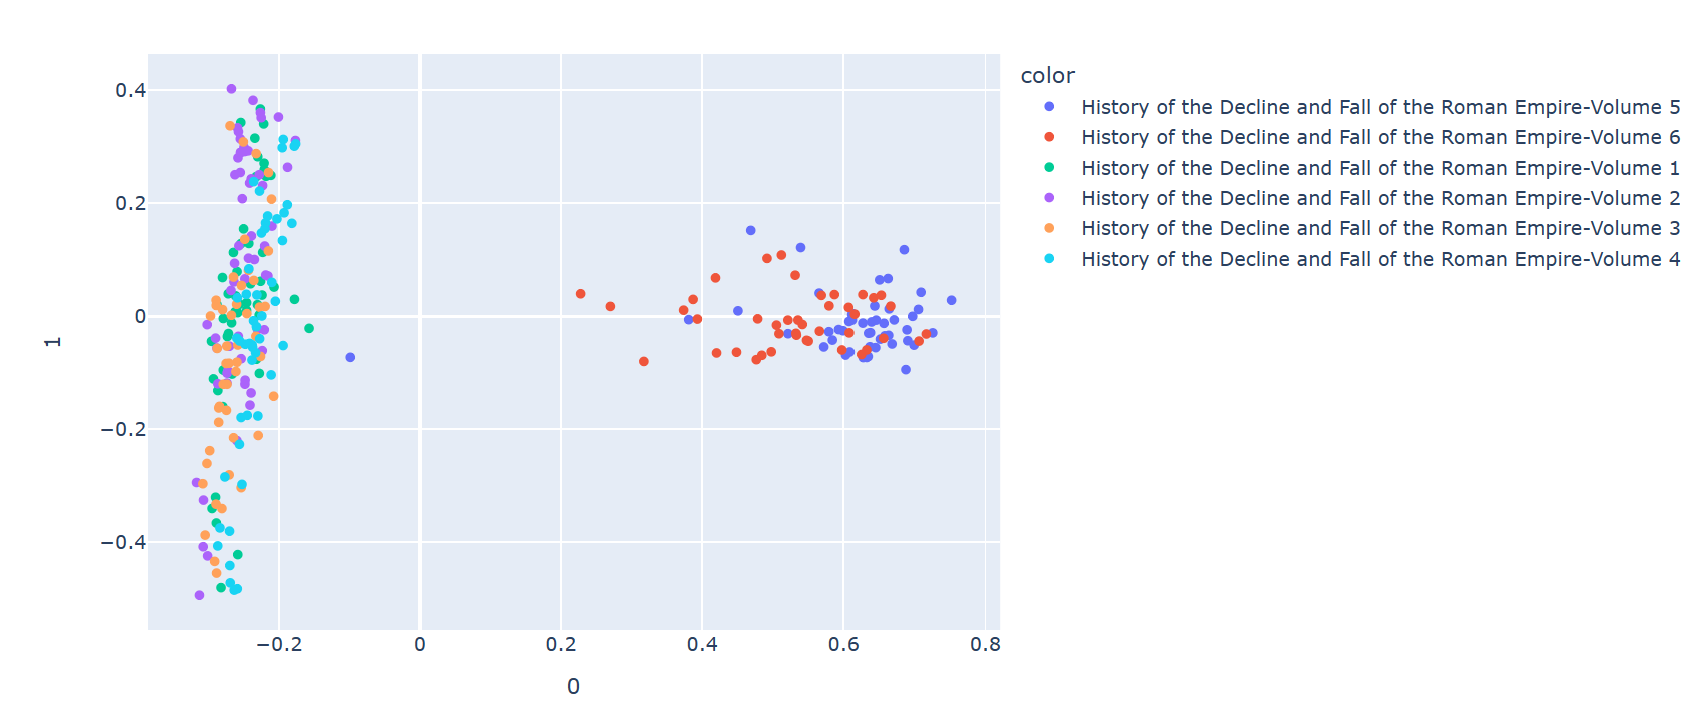

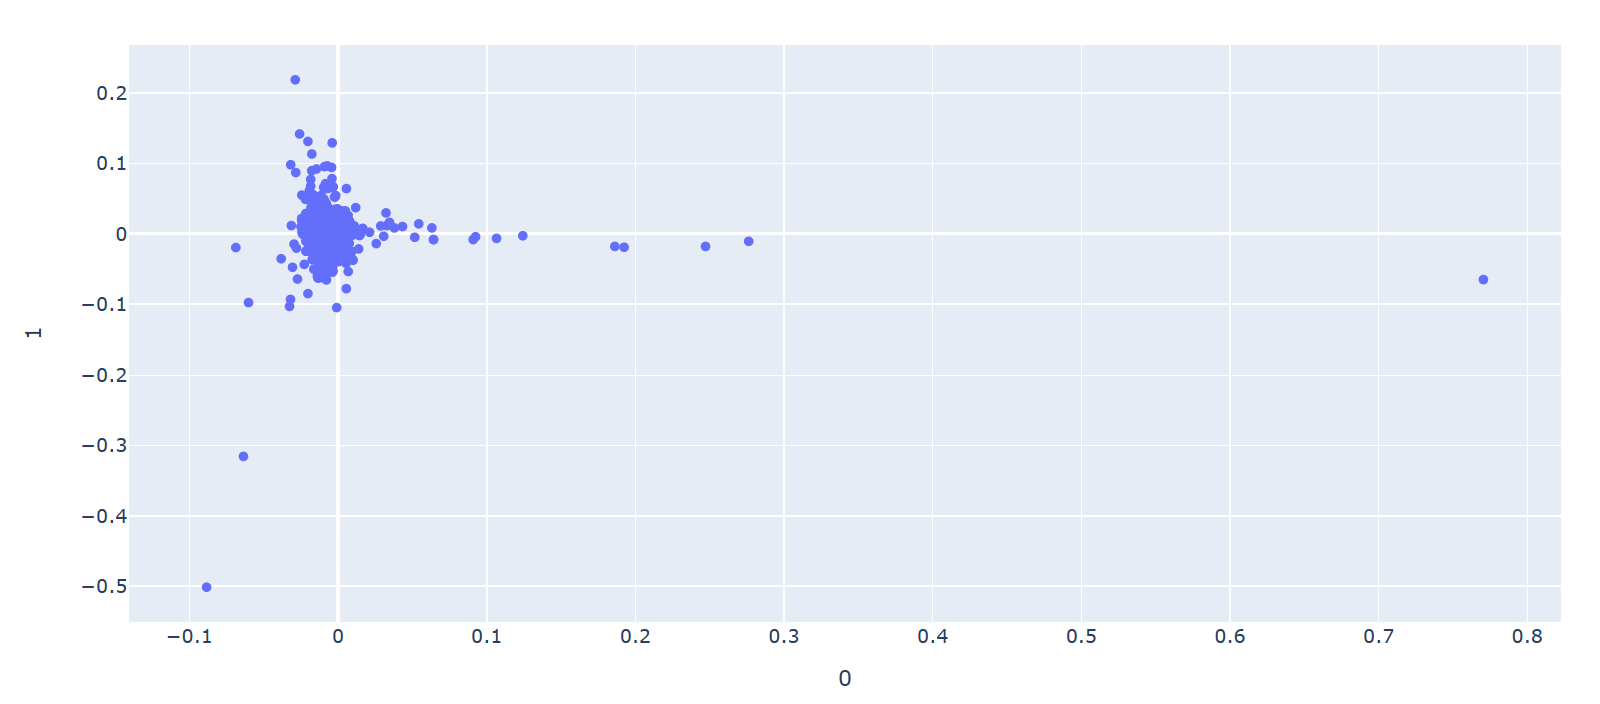

Briefly describe the nature of the polarity you see in the first component:

The data points are clustered closely together for the first four volumes which indicates that this component captures little variance in the text data. There is also another cluster pertaining to Volume 5 and Volume 6, which indicates that there are major differences in the text for volumes 5 and 6 and the rest. The points in this second cluster are also more spread out suggesting the component captures more variance within that cluster.

### Creating DOC

In [60]:
DOC = pd.DataFrame(index=TFIDF_L2.index).join(LIB)

### Scatter of documents in space created by the first two components
Colored by title of book

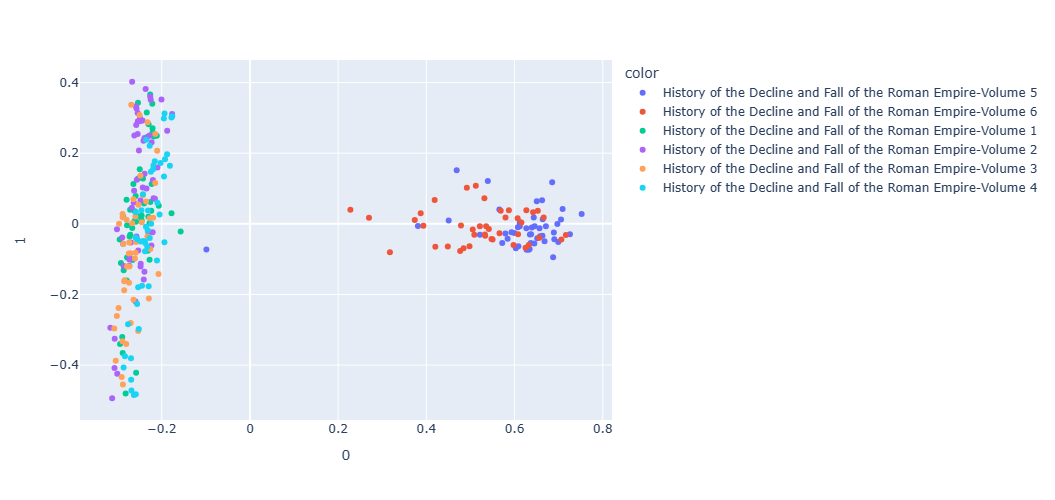

In [61]:
px.scatter(DCM, 0, 1, 
           color=DOC.title, height=500)

### Scatter of loadings for first two components

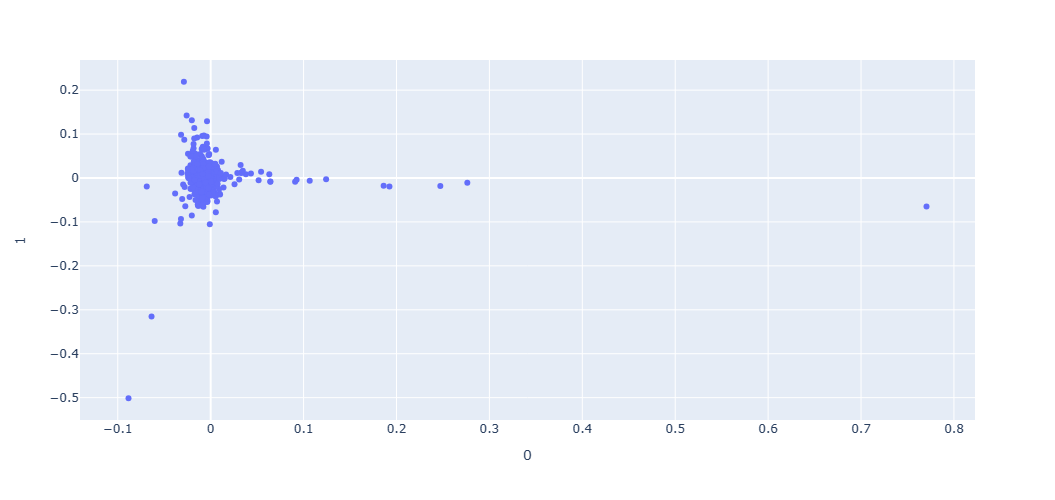

In [62]:
px.scatter(LOADINGS.join(VOCAB).reset_index(), 0, 1, height=500)

## PCA Visualization 2 (4)

Include a scatterplot of documents in the space created by the second two components.

Color the points based on a metadata feature associated with the documents.

Also include a scatterplot of the loadings for the same two components. (This does not need a feature mapped onto color.)

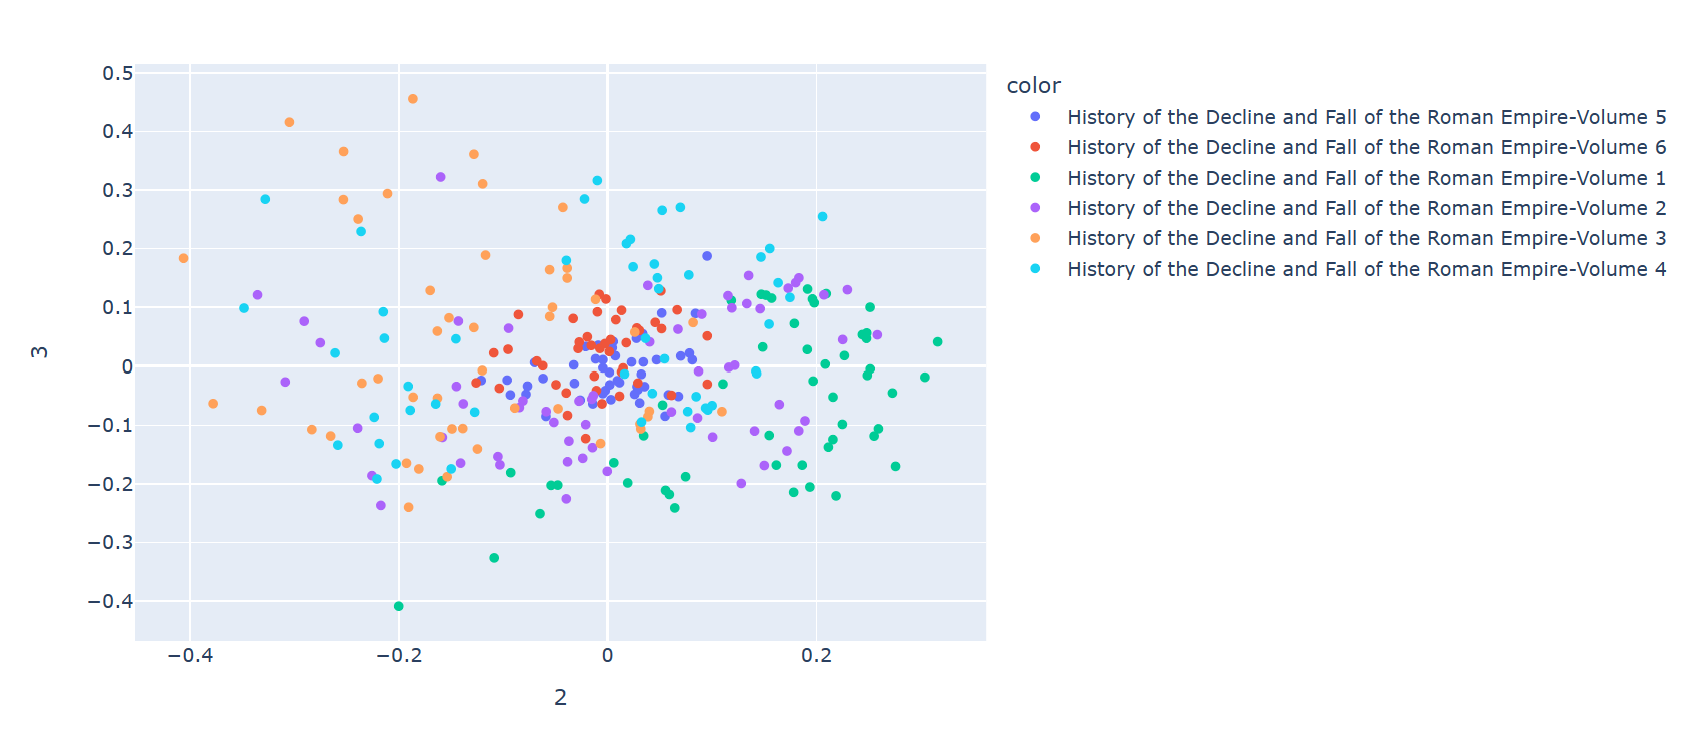

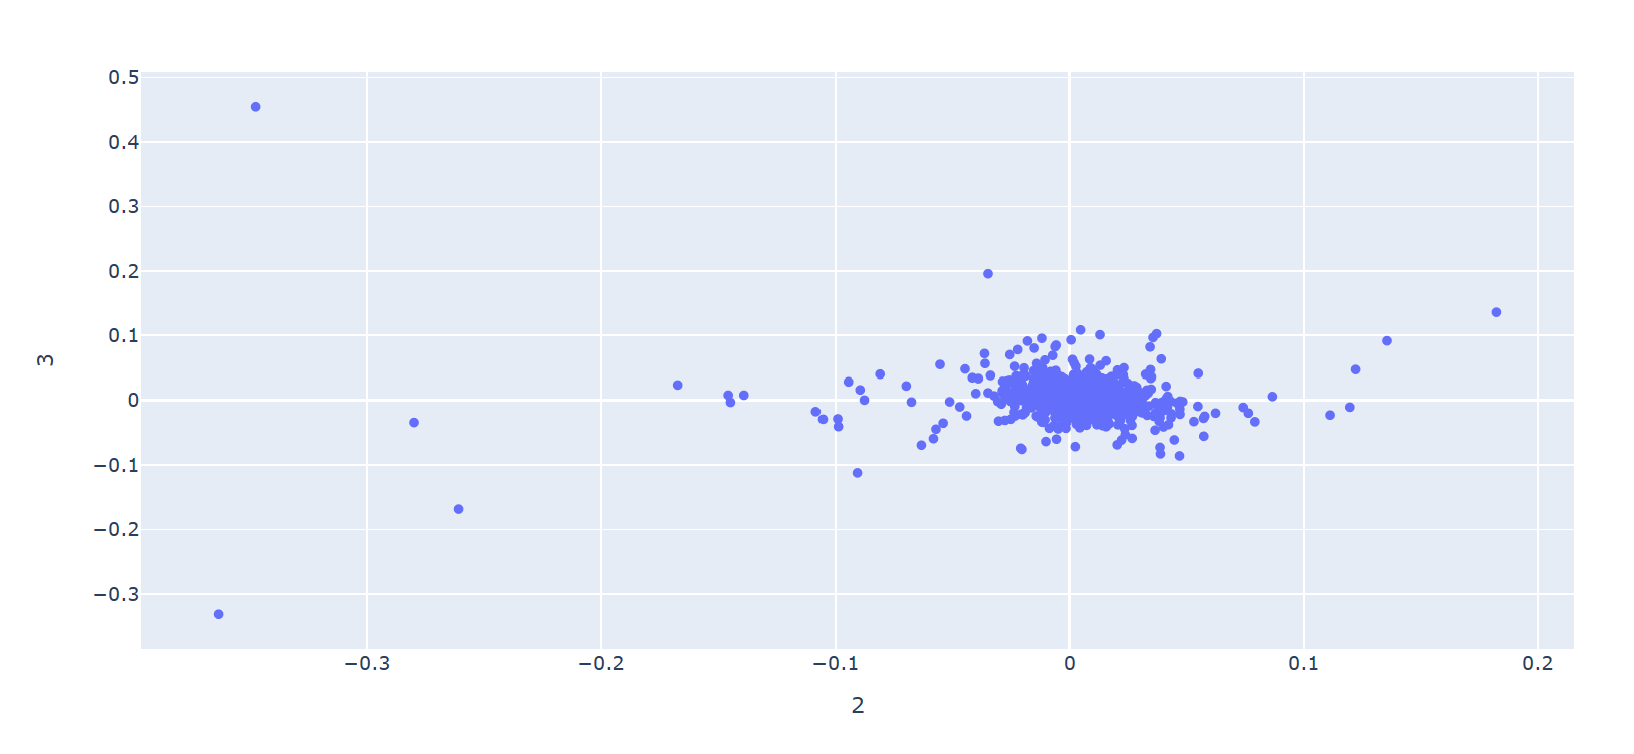

Briefly describe the nature of the polarity you see in the second component:

The clusters are less pronounces than displayed on the previous plots, and the points are much more spread out. This indicates that the second component captures a lot of variance within and between the texts.

### Scatter of documents in created by second two components
Used title as the color

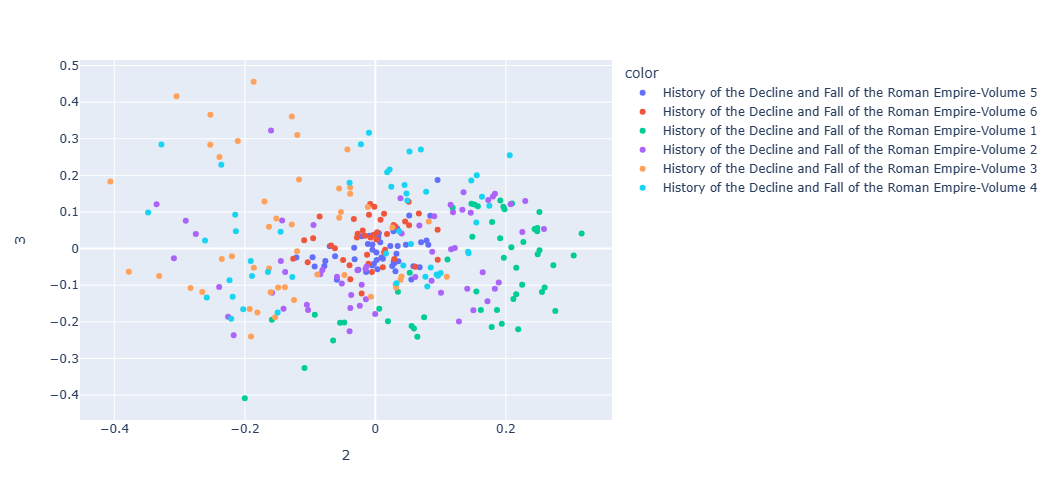

In [63]:
px.scatter(DCM, 2, 3, 
           color=DOC.title, height=500)

### Scatter of loadings of second two components

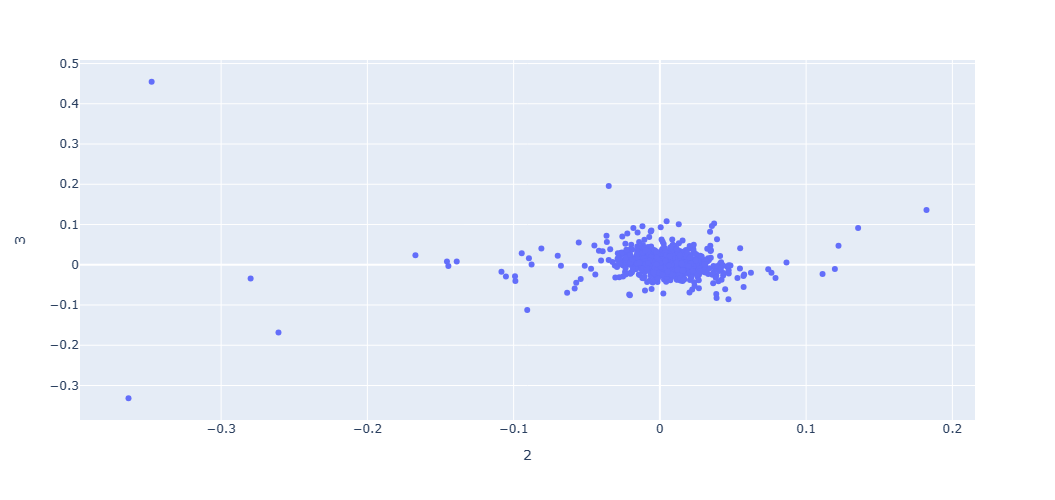

In [64]:
px.scatter(LOADINGS.join(VOCAB).reset_index(), 2, 3, height=500)

## LDA TOPIC (4)

- UVA Box URL: https://virginia.box.com/s/awc6fw7u626t51z3oo822wsdeejh6ijt
- UVA Box URL of count matrix used to create: https://virginia.box.com/s/qusaca87exa9w0rmy5y1y4wxrmlvh6iq
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Libary used to compute: CountVectorizer, LatentDirichletAllocation
- A description of any filtering, e.g. POS (Nouns and Verbs only): Filtered by nouns only
- Number of components: 5
- Any other parameters used: ngram_range = (1, 2), n_terms = 4000, max_iter = 5, n_top_terms = 5
- Top 5 words and best-guess labels for topic five topics by mean document weight:
  - T00: emperor empire people death provinces
  - T01: arms city war country army
  - T02: tom ii iii emperor years
  - T03: church religion faith bishops zeal	
  - T04:laws jurisprudence law citizen civilians

In [65]:
TOKENS = CORPUS[['pos', 'term_str']]

In [66]:
TOKENS

pos      term_str
book_id chap_id para_num sent_num token_num                   
735     1       0        0        0          NNP  introduction
                                  1          NNP       worship
                                  2           CC           and
                                  3          NNP   persecution
                                  4           IN            of
...                                          ...           ...
893     48      8        0        50         NNP     alexander
                9        0        0           NN           end
                                  1           IN            of
                                  2          NNP           vol
                         1        0           NN            iv

[1233321 rows x 2 columns]

In [67]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 5
max_iter = 5
n_top_terms = 5

BAG = ['book_id', 'chap_id']
colors = "YlGnBu"

In [68]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(BAG).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [69]:
DOCS

doc_str
book_id chap_id                                                   
735     1        connection church state subservient only relat...
        2        epistles emperor models eloquence logic portra...
        3        obligations popes family link ancient modern h...
        4        synod reign popes separation translation empir...
        5        outlines picture empire extended east west nor...
...                                                            ...
893     44       plan emperors series emperors fortunes reigns ...
        45       allies wife sense honor gratitude heap gold co...
        46       part policy preserved century institution marr...
        47       warriors elevation standard rewards stature st...
        48       premature death sons survivors judgment affect...

[297 rows x 1 columns]

In [70]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()

In [71]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [72]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [73]:
lda_model = lda_engine.fit_transform(count_model)

### Top 5 words

In [74]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [247]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

In [248]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES

In [249]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [250]:
TOPICS = TOPICS.sort_values('doc_weight_sum', ascending=False)

In [252]:
labels = ['empire structure and government', 'war and conflict', 'emperors and their terms', 'religion', 'laws and society']
TOPICS['labels'] = labels

In [253]:
TOPICS.style.background_gradient(cmap=colors, axis=None)

In [176]:
#TOPICS.to_csv('TOPICS.csv', index=True)

## LDA THETA (4)

- UVA Box URL: https://virginia.box.com/s/h1azw0f0tcd49kkkdc1qfldxjdxevnqv
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','

In [174]:
THETA_tab = THETA.T

In [181]:
#THETA_tab.to_csv('THETA.csv', index=True)

In [81]:
THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

## LDA PHI (4)

- UVA Box URL: https://virginia.box.com/s/qusaca87exa9w0rmy5y1y4wxrmlvh6iq
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','

In [179]:
PHI_tab = PHI.T

In [182]:
#PHI_tab.to_csv('PHI.csv', index=True)

In [83]:
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

## LDA + PCA Visualization (4)

Apply PCA to the PHI table and plot the topics in the space opened by the first two components.

Size the points based on the mean document weight of each topic (using the THETA table).

Color the points basd on a metadata feature from the LIB table.

Provide a brief interpretation of what you see.

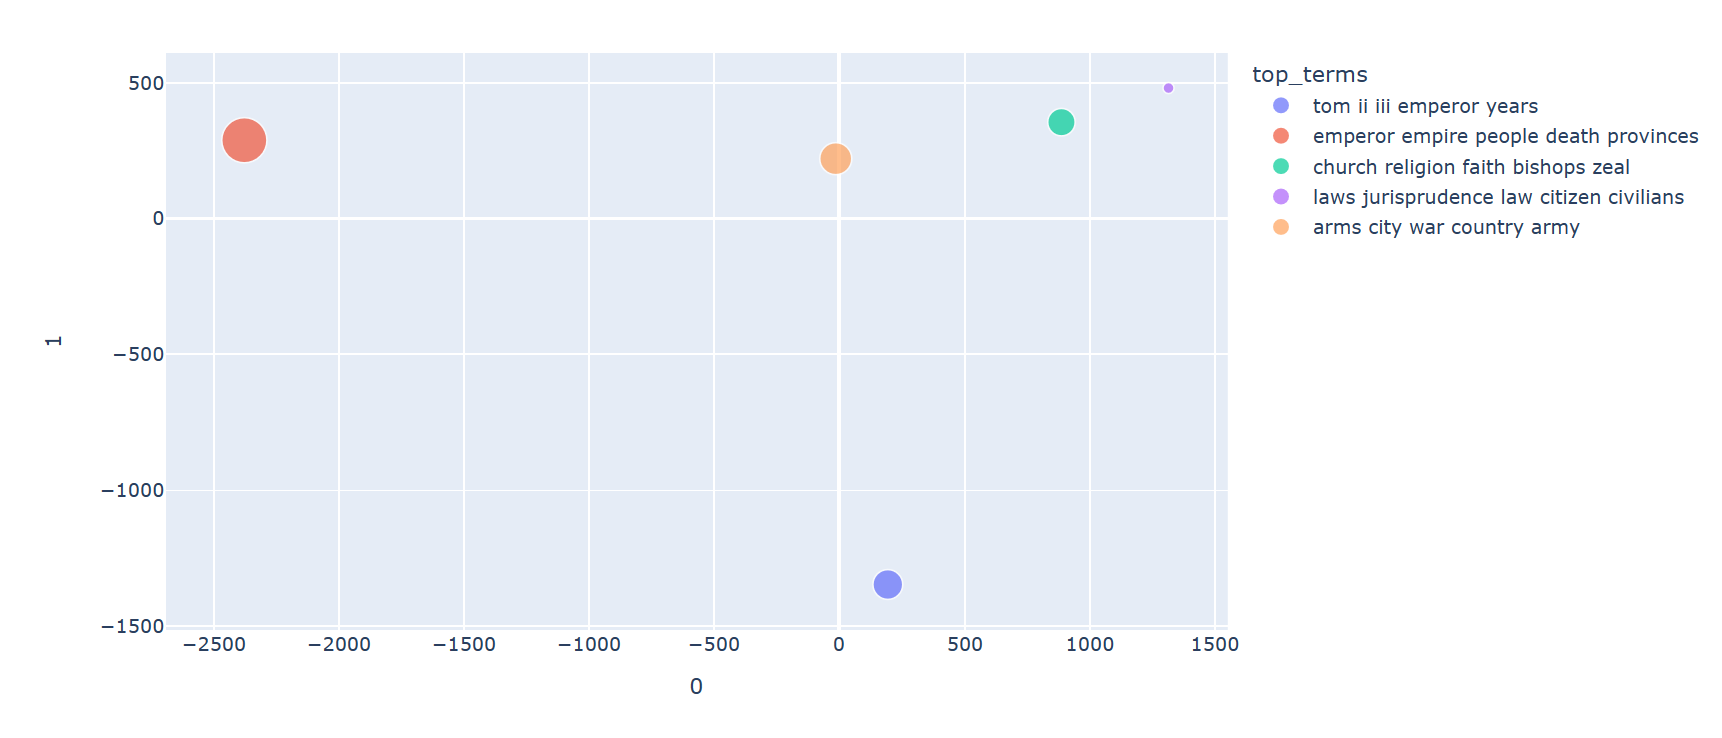

The most densely weighted topic is spread out far away from the other topics along component 0 indicating that the component captures a lot of variation between this topic and the other topics.

In [84]:
LOADINGS_LDA, DCM_LDA, COMPINF_LDA = get_pca(PHI, 
                                 norm_docs=False, 
                                 norm_level=2)

In [85]:
DCM_LDA = DCM_LDA.join(TOPICS)

In [86]:
DCM_LDA

0            1            2           3             4  \
topic_id                                                                    
T0         191.400137 -1347.432468   -86.415277   44.241830  1.234568e-13   
T1       -2378.595639   289.017978  -303.230134   94.636182  3.250733e-13   
T2         885.865341   355.693392  -539.041423 -495.165542 -2.122746e-13   
T3        1314.214670   481.737492  -162.186967  497.230282 -1.598721e-13   
T4         -12.884510   220.983606  1090.873801 -140.942751 -5.817569e-14   

                     5             6             7             8  \
topic_id                                                           
T0        1.318945e-13  1.467715e-13  5.062617e-14  1.119105e-13   
T1       -1.723066e-13  1.545430e-13 -2.229328e-13 -1.838529e-13   
T2       -9.992007e-15 -1.743050e-13  1.154632e-13 -6.750156e-14   
T3       -1.412204e-13 -1.465494e-13  5.861978e-14 -1.616485e-13   
T4        7.149836e-14 -4.440892e-15 -1.257883e-13 -5.195844e-14   

                     9                                 top_terms  \
topic_id                                                           
T0        8.482104e-14                  tom ii iii emperor years   
T1       -3.661516e-13     emperor empire people death provinces   
T2        2.114975e-13        church religion faith bishops zeal   
T3        2.664535e-15  laws jurisprudence law citizen civilians   
T4        4.085621e-14                arms city war country army   

          doc_weight_sum  term_freq  
topic_id                             
T0             54.652055   0.232201  
T1            125.465578   0.401885  
T2             46.262551   0.122053  
T3              7.615574   0.023682  
T4             63.004243   0.220179

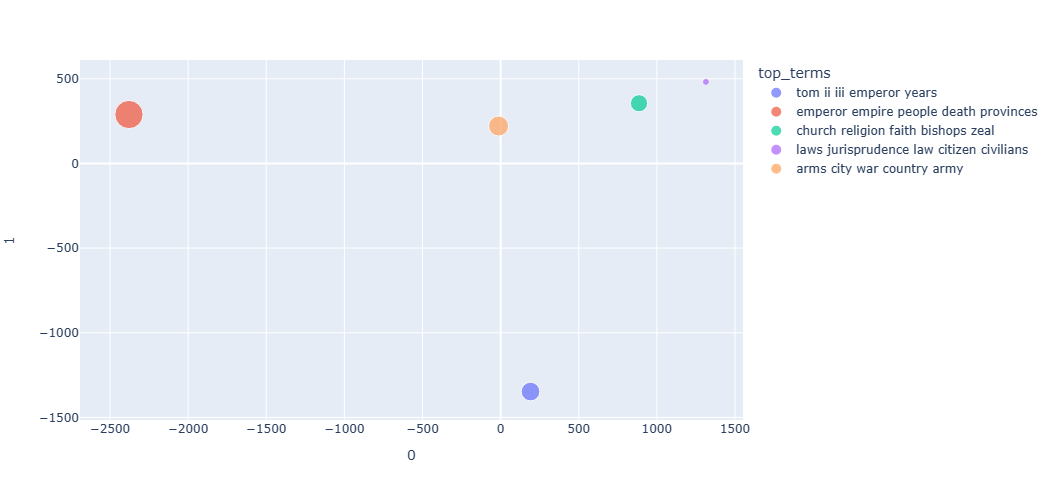

In [230]:
px.scatter(DCM_LDA, 0, 1, 
           size = "doc_weight_sum", color = "top_terms", height=500)

## Sentiment VOCAB_SENT (4)

Sentiment values associated with a subset of the VOCAB from a curated sentiment lexicon.

- UVA Box URL: https://virginia.box.com/s/l3s2et3048mo9kror4gws06jhv85pdrg
- UVA Box URL for source lexicon: https://virginia.box.com/s/hcnwq7j1g76jt0hahdnlpbo8vj4itvxv
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','

In [88]:
salex_csv = f'{data_home}/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

In [89]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [90]:
SALEX

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  sentiment  
term_str                                          
abandon            1         0      0         -1  
abandoned          1         0      0         -1  
abandonment        1         1      0         -1  
abduction          1         1      0         -1  
aberration         0         0      0         -1  
...              ...       ...    ...        ...  
young              0         1      0          1  
youth              0         1      0          1  
zeal               0         1      1          1  
zealous            0         0      1          1  
zest               0         0      1          1  

[3688 rows x 11 columns]

In [193]:
#SALEX.to_csv('SALEX.csv', index=True)

In [91]:
VOCAB_SENT = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)

In [92]:
VOCAB_SENT = VOCAB_SENT.dropna(axis=1)
VOCAB_SENT

n  n_chars             p          i max_pos max_pos_group  \
term_str                                                                   
abandon       44        7  3.568115e-05  14.774478      VB            VB   
abandoned    175        9  1.419137e-04  12.782699     VBN            VB   
abandonment    2       11  1.621871e-06  19.233910      NN            NN   
aberration     1       10  8.109353e-07  20.233910      NN            NN   
abhor          9        5  7.298418e-06  17.063985      VB            VB   
...          ...      ...           ...        ...     ...           ...   
wretched      31        8  2.513899e-05  15.279714      JJ            JJ   
young        150        5  1.216403e-04  13.005091      JJ            JJ   
youth        406        5  3.292397e-04  11.568574      NN            NN   
zeal         488        4  3.957364e-04  11.303173      NN            NN   
zealous       46        7  3.730302e-05  14.710348      JJ            JJ   

            porter_stem  stop       dfidf  anger  anticipation  disgust  fear  \
term_str                                                                        
abandon         abandon     0  119.886338      0             0        0     1   
abandoned       abandon     0  153.862811      1             0        0     1   
abandonment     abandon     0   14.428638      1             0        0     1   
aberration        aberr     0    8.214319      0             0        1     0   
abhor             abhor     0   45.399547      1             0        1     1   
...                 ...   ...         ...    ...           ...      ...   ...   
wretched         wretch     0   99.222856      0             0        1     0   
young             young     0  155.021942      0             1        0     0   
youth             youth     0  116.676658      1             1        0     1   
zeal               zeal     0  115.822575      0             1        0     0   
zealous          zealou     0  117.127452      0             0        0     0   

             joy  negative  positive  sadness  surprise  trust  sentiment  
term_str                                                                   
abandon        0         1         0        1         0      0         -1  
abandoned      0         1         0        1         0      0         -1  
abandonment    0         1         0        1         1      0         -1  
aberration     0         1         0        0         0      0         -1  
abhor          0         1         0        0         0      0         -1  
...          ...       ...       ...      ...       ...    ...        ...  
wretched       0         1         0        1         0      0         -1  
young          1         0         1        0         1      0          1  
youth          1         0         1        0         1      0          1  
zeal           1         0         1        0         1      1          1  
zealous        1         0         1        0         0      1          1  

[2199 rows x 20 columns]

In [184]:
#VOCAB_SENT.to_csv('VOCAB_SENT.csv', index=True)

## Sentiment BOW_SENT (4)

Sentiment values from VOCAB_SENT mapped onto BOW.

- UVA Box URL: https://virginia.box.com/s/354zbk346yqtk68aenen0cqtnk36antl
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','

In [93]:
BOW_SENT = BOW.join(VOCAB_SENT[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [94]:
BOW_SENT

n     tfidf max_pos  anger  anticipation  disgust  \
book_id chap_id term_str                                                       
735     1       abandoned  2  0.003082     VBN    1.0           0.0      0.0   
                absence    2  0.004456      NN    0.0           0.0      0.0   
                abuse      2  0.004497      NN    1.0           0.0      1.0   
                abyss      1  0.005324      NN    0.0           0.0      0.0   
                accused    3  0.006561     VBN    1.0           0.0      0.0   
...                       ..       ...     ...    ...           ...      ...   
893     48      words      1  0.001943     NNS    1.0           0.0      0.0   
                wound      1  0.003724      NN    1.0           0.0      0.0   
                young      4  0.009871      JJ    0.0           1.0      0.0   
                youth      4  0.003394      NN    1.0           1.0      0.0   
                zeal       2  0.001676      NN    0.0           1.0      0.0   

                           fear  joy  sadness  surprise  trust  sentiment  
book_id chap_id term_str                                                   
735     1       abandoned   1.0  0.0      1.0       0.0    0.0       -1.0  
                absence     1.0  0.0      1.0       0.0    0.0       -1.0  
                abuse       1.0  0.0      1.0       0.0    0.0       -1.0  
                abyss       1.0  0.0      1.0       0.0    0.0       -1.0  
                accused     1.0  0.0      0.0       0.0    0.0       -1.0  
...                         ...  ...      ...       ...    ...        ...  
893     48      words       0.0  0.0      0.0       0.0    0.0       -1.0  
                wound       1.0  0.0      1.0       0.0    0.0       -1.0  
                young       0.0  1.0      0.0       1.0    0.0        1.0  
                youth       1.0  1.0      0.0       1.0    0.0        1.0  
                zeal        0.0  1.0      0.0       1.0    1.0        1.0  

[69200 rows x 12 columns]

In [188]:
#BOW_SENT.to_csv('BOW_SENT.csv', index=True)

## Sentiment DOC_SENT (4)

Computed sentiment per bag computed from BOW_SENT.

- UVA Box URL: https://virginia.box.com/s/m8204q5bcqujjqhojiyt706zhg65ni9m
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Document bag expressed in terms of OHCO levels: ['book_id, 'chap_id']

In [95]:
DOC_SENT = BOW_SENT.groupby(['book_id', 'chap_id'])[emo_cols].mean()

In [96]:
DOC_SENT

anger  anticipation   disgust      fear       joy  \
book_id chap_id                                                         
735     1        0.325879      0.223642  0.185304  0.354633  0.274760   
        2        0.338078      0.220641  0.199288  0.362989  0.238434   
        3        0.290323      0.245968  0.201613  0.314516  0.290323   
        4        0.292181      0.263374  0.176955  0.341564  0.304527   
        5        0.333333      0.236434  0.251938  0.344961  0.275194   
...                   ...           ...       ...       ...       ...   
893     44       0.295455      0.253247  0.227273  0.373377  0.279221   
        45       0.327078      0.230563  0.214477  0.383378  0.243968   
        46       0.253776      0.250755  0.205438  0.338369  0.344411   
        47       0.332402      0.215084  0.206704  0.365922  0.254190   
        48       0.315927      0.234987  0.221932  0.386423  0.271540   

                  sadness  surprise     trust  sentiment  
book_id chap_id                                           
735     1        0.268371  0.137380  0.415335   0.000000  
        2        0.266904  0.081851  0.405694  -0.049822  
        3        0.245968  0.145161  0.459677   0.080645  
        4        0.271605  0.144033  0.460905   0.111111  
        5        0.275194  0.139535  0.387597  -0.038760  
...                   ...       ...       ...        ...  
893     44       0.321429  0.129870  0.373377  -0.022727  
        45       0.321716  0.107239  0.345845  -0.093834  
        46       0.262840  0.154079  0.419940   0.117825  
        47       0.296089  0.125698  0.391061  -0.030726  
        48       0.321149  0.135770  0.355091  -0.112272  

[297 rows x 9 columns]

In [187]:
#DOC_SENT.to_csv('DOC_SENT.csv', index=True)

## Sentiment Plot (4)

Plot sentiment over some metric space, such as time.

If you don't have a metric metadata features, plot sentiment over a feature of your choice.

You may use a bar chart or a line graph.

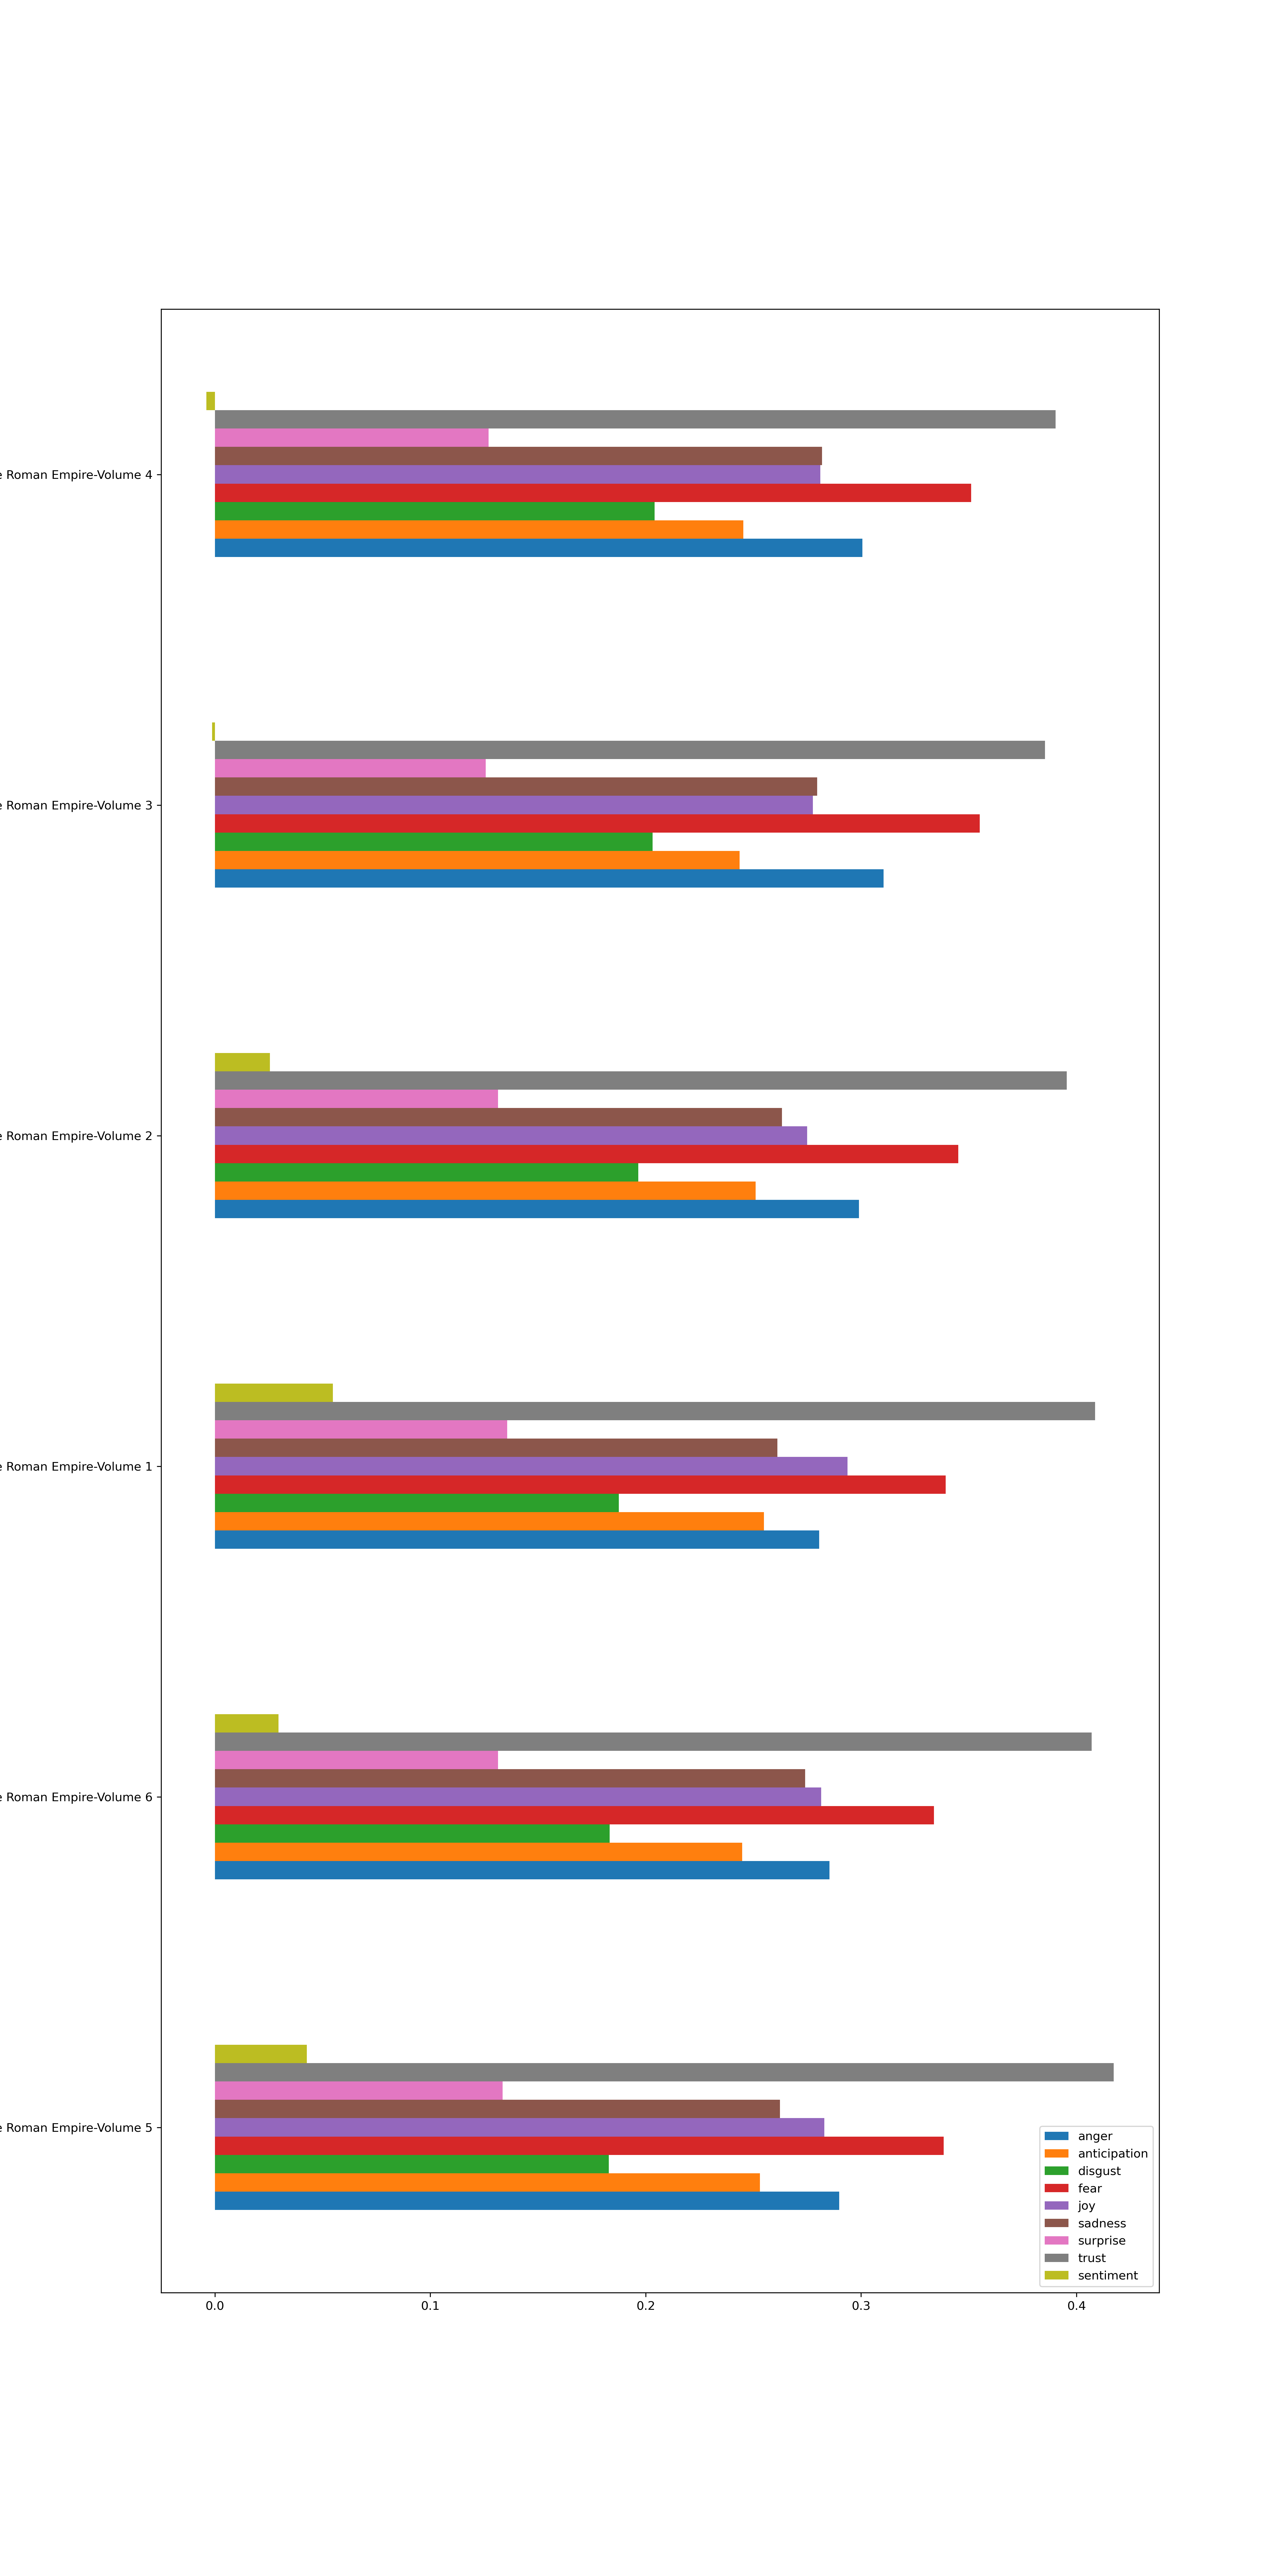

In [231]:
DOC_SENT2 = BOW_SENT.groupby(['book_id'])[emo_cols].mean()

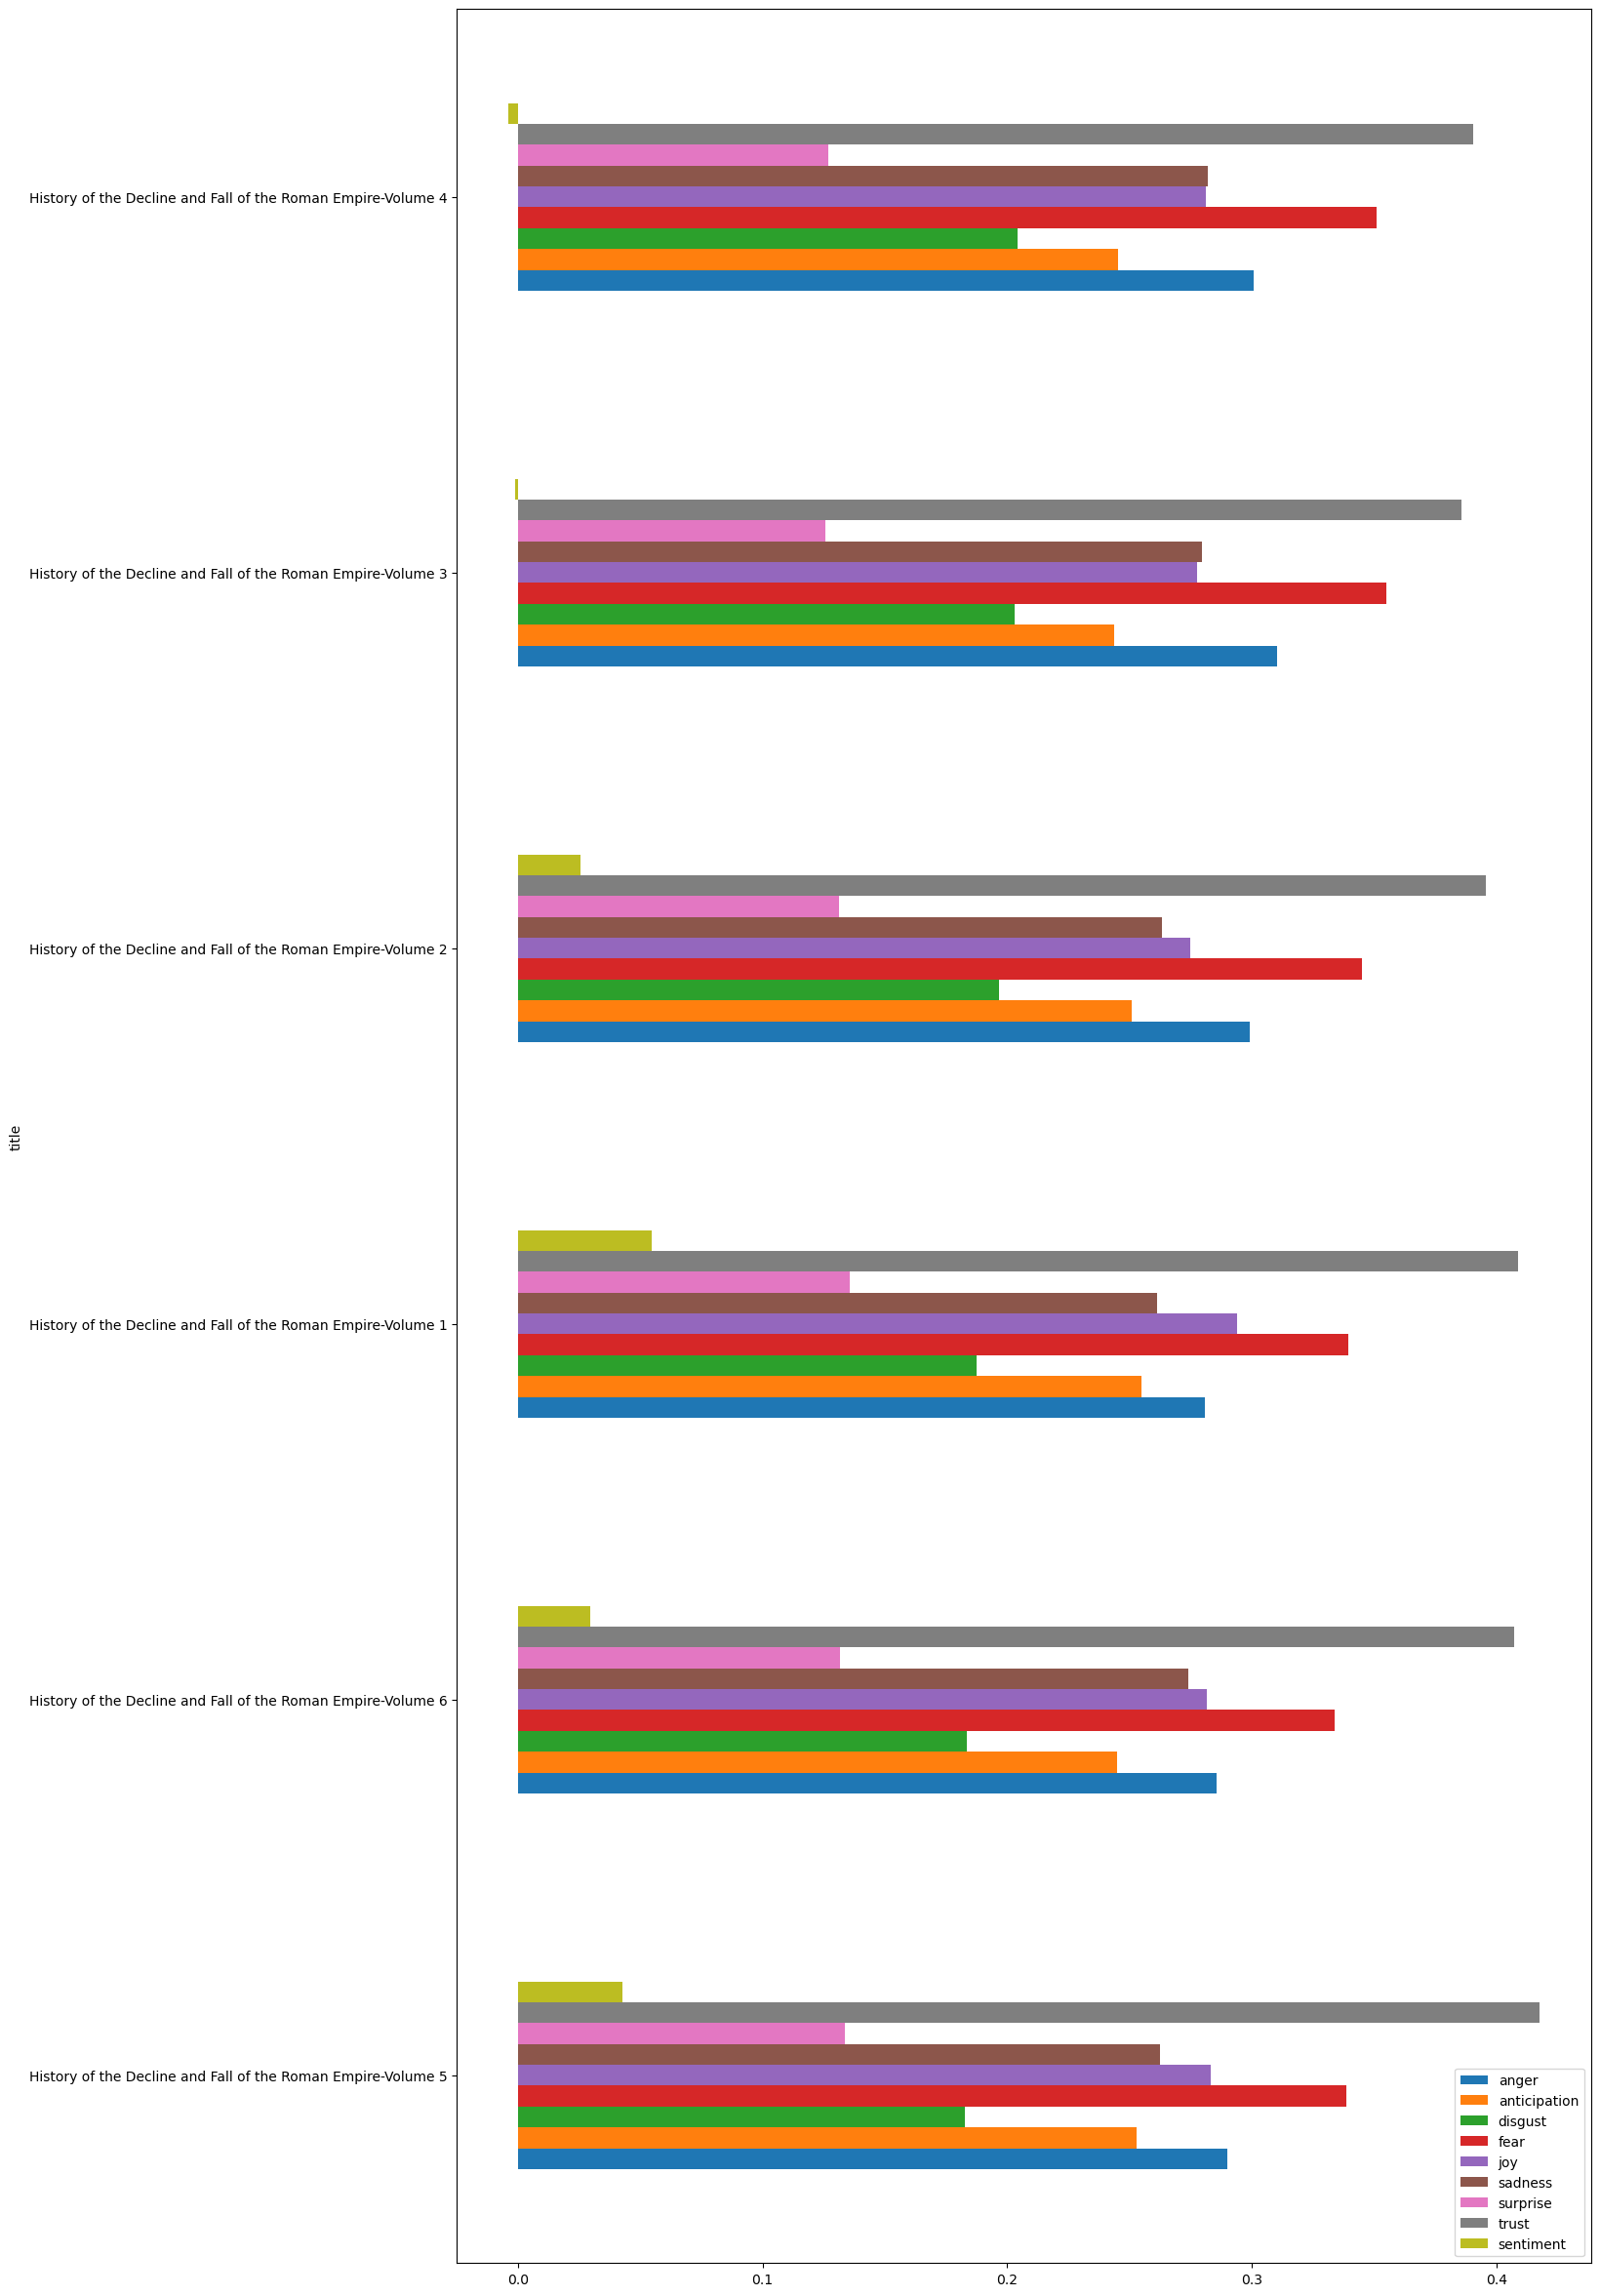

In [232]:
DOC_SENT2.index = LIB.title
ax = DOC_SENT2.plot.barh(figsize=(15,30))

In [233]:
ax.figure.savefig('Sentiment_plot.png', dpi=300)  # Save the figure as a PNG file

## VOCAB_W2V (4)

A table of word2vec features associated with terms in the VOCAB table.

- UVA Box URL: https://virginia.box.com/s/ikl32ujbyu5w3871ew28ga99m3szcklt
- GitHub URL for notebook used to create: https://github.com/WillSivolella/TextAnalyticsFinalProject/FinalProject.ipynb
- Delimitter: ','
- Document bag expressed in terms of OHCO levels: 'book_id', 'chap_id'
- Number of features generated: 246
- The library used to generate the embeddings: word2vec

In [99]:
# word2vec parameters
w2v_params = dict(
    window = 5,
    vector_size = 246,
    min_count = 50, # THIS LIMITS OUR VOCAB
    workers = 4
)

In [100]:
docs = TOKENS[~TOKENS.pos.str.match('NNPS?')].dropna(subset=['term_str'])\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
docs = [doc for doc in docs if len(doc) > 1] # Lose single word docs

In [101]:
vocab = Dictionary(docs)

In [102]:
model = word2vec.Word2Vec(docs, **w2v_params)

In [103]:
def get_vector(row):
    w = row.name
    try:
        vec = model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [104]:
VOCAB_W2V = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [105]:
VOCAB_W2V

0         1         2         3         4         5    \
term_str                                                               
1        -0.332966 -0.578181  0.865984  0.570610 -0.336836 -0.666603   
10       -0.238109 -0.616701  0.658144  0.407978 -0.147027 -0.457784   
11       -0.201146 -0.446787  0.473767  0.328707 -0.232883 -0.308951   
12       -0.243710 -0.365240  0.591924  0.312362 -0.234811 -0.484853   
13       -0.230054 -0.509924  0.682787  0.451211 -0.210983 -0.461193   
...            ...       ...       ...       ...       ...       ...   
younger  -0.142408  0.006289  0.132413 -0.016931 -0.018935 -0.193084   
your      0.246205  1.149831 -0.328288 -0.769204  0.256551  0.604537   
youth    -0.123156 -0.432208  0.185610  0.194588  0.115866 -0.196517   
youths   -0.060576 -0.506124  0.060677 -0.050942 -0.027403 -0.116501   
zeal      0.182307 -0.304900 -0.013091  0.366810  0.294182  0.345102   

               6         7         8         9    ...       236       237  \
term_str                                          ...                       
1        -0.548876 -0.515373 -0.148614  0.220214  ... -0.065801 -0.790731   
10       -0.501320 -0.302734 -0.158504  0.096158  ... -0.081516 -0.510663   
11       -0.369120 -0.309930 -0.126178  0.077630  ... -0.065483 -0.502026   
12       -0.398616 -0.313847 -0.133354  0.076992  ... -0.041470 -0.575035   
13       -0.357994 -0.354456 -0.151133  0.121480  ... -0.139353 -0.561859   
...            ...       ...       ...       ...  ...       ...       ...   
younger  -0.338773  0.039117 -0.362186 -0.207425  ...  0.026722  0.188236   
your     -0.089041 -0.079345  0.096673 -0.044015  ...  0.153569  0.011201   
youth    -0.428983  0.219999 -0.387015 -0.285073  ...  0.060059  0.608786   
youths   -0.000844  0.093440 -0.102680 -0.056530  ... -0.149351  0.230211   
zeal     -0.041790  0.336640 -0.342350 -0.201004  ...  0.211061  0.425263   

               238       239       240       241       242       243  \
term_str                                                               
1         0.283719 -0.265678 -0.236680 -0.020583 -0.212479 -0.079040   
10        0.257817 -0.109991 -0.127938 -0.063469 -0.109339 -0.111822   
11        0.249011 -0.091691 -0.098892 -0.098054 -0.073651 -0.179137   
12        0.207268 -0.178452 -0.123678 -0.040165 -0.129525 -0.132061   
13        0.279427 -0.076679 -0.149321 -0.009013 -0.084214 -0.062010   
...            ...       ...       ...       ...       ...       ...   
younger   0.104003  0.014600 -0.155547 -0.112974 -0.137634  0.078467   
your      0.507069  0.389945 -0.090413 -0.247724  0.634803 -0.278347   
youth     0.142660 -0.053315  0.010242  0.016166  0.040570  0.111524   
youths   -0.052821  0.032267  0.070534  0.018959  0.009447 -0.112326   
zeal      0.128193  0.638365 -0.032920  0.240248  0.056750  0.513027   

               244       245  
term_str                      
1        -0.196954 -0.368237  
10       -0.224396 -0.257221  
11       -0.172139 -0.210211  
12       -0.154652 -0.313750  
13       -0.198167 -0.313288  
...            ...       ...  
younger  -0.081571  0.043633  
your     -0.212347  0.354536  
youth     0.054585  0.140344  
youths    0.093804  0.154777  
zeal     -0.087454  0.158719  

[2664 rows x 246 columns]

In [190]:
#VOCAB_W2V.to_csv('VOCAB_W2V.csv', index=True)

## Word2vec tSNE Plot (4)

Plot word embedding featues in two-dimensions using t-SNE.

Describe a cluster in the plot that captures your attention.

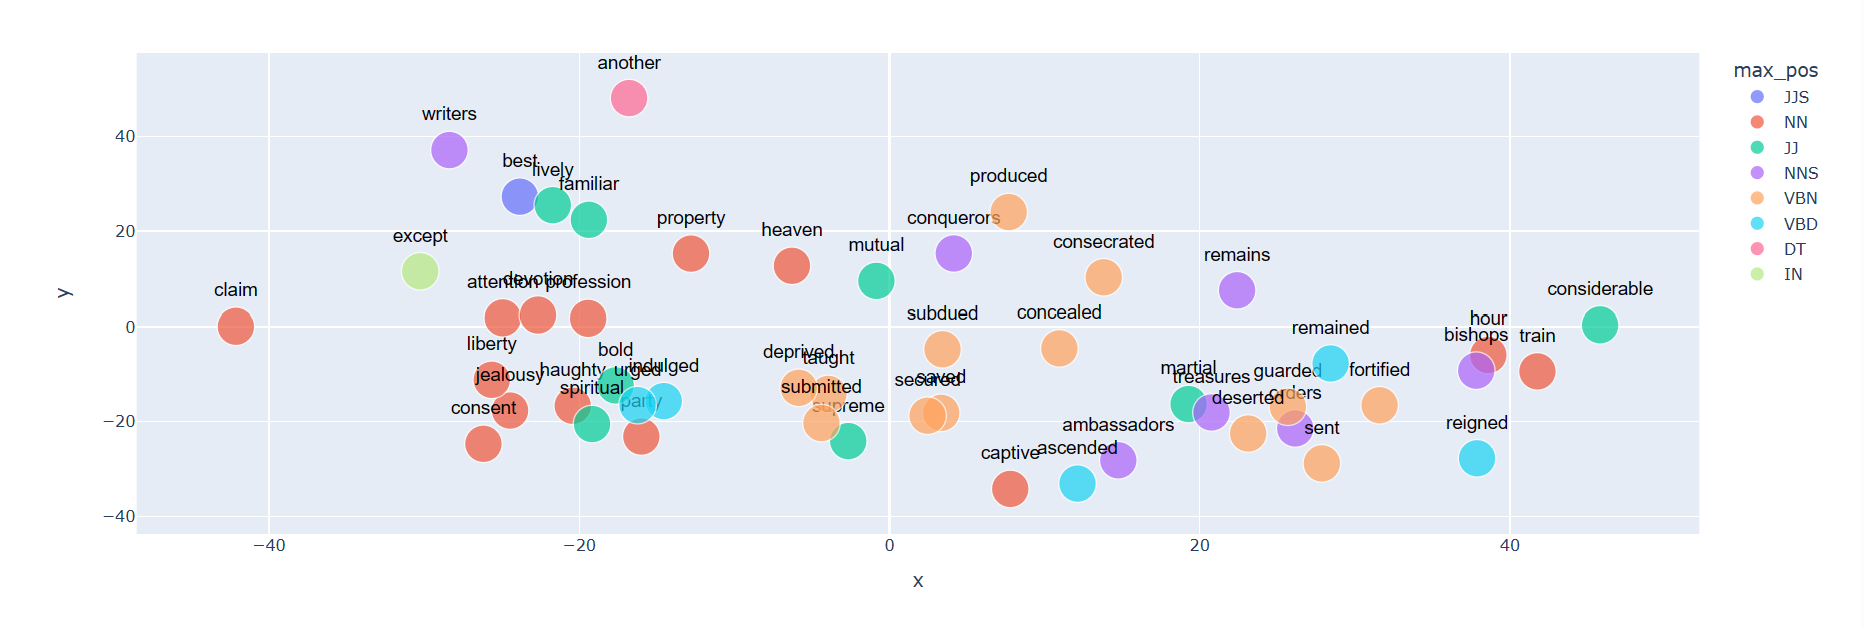

In the t-SNE plot, the top-left quadrant contains words like "writers" and "except," which suggest more abstract, intellectual discussions or meta-narrative elements. The bottom-left is populated by assertive terms such as "claim" and "deprived," potentially themes of conflict or possession. The top-right quadrant includes nouns and adjectives like "conquerors" and "ambassadors," indicating central roles across the volumes. The bottom-right quadrant focuses on terms associated with governance, such as "reigned" and "fortified," reflecting the text's emphasis on historical and governmental contexts.

In [106]:
tsne_engine = tsne(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_model = tsne_engine.fit_transform(VOCAB_W2V.to_numpy())
TSNE = pd.DataFrame(tsne_model, columns=['x','y'], index=VOCAB_W2V.index)

In [107]:
TSNE

x          y
term_str                      
1        -32.359428  45.398922
10       -30.012737  44.496212
11       -27.396280  44.659344
12       -28.828100  45.424004
13       -30.396313  43.867081
...             ...        ...
younger   -1.261409 -35.554333
your     -44.164055  13.721626
youth      0.545569 -36.243328
youths    33.584564 -11.560237
zeal     -28.614443 -13.498083

[2664 rows x 2 columns]

In [108]:
X = TSNE.join(VOCAB, how='left')

In [109]:
X

x          y    n  n_chars         p          i max_pos  \
term_str                                                                    
1        -32.359428  45.398922  207        1  0.000168  12.540423      CD   
10       -30.012737  44.496212   98        2  0.000079  13.619200      CD   
11       -27.396280  44.659344   90        2  0.000073  13.742057      CD   
12       -28.828100  45.424004   92        2  0.000075  13.710348      CD   
13       -30.396313  43.867081  105        2  0.000085  13.519664      CD   
...             ...        ...  ...      ...       ...        ...     ...   
younger   -1.261409 -35.554333  123        7  0.000100  13.291395     JJR   
your     -44.164055  13.721626  388        4  0.000315  11.633997    PRP$   
youth      0.545569 -36.243328  406        5  0.000329  11.568574      NN   
youths    33.584564 -11.560237   72        6  0.000058  14.063985     NNS   
zeal     -28.614443 -13.498083  488        4  0.000396  11.303173      NN   

         max_pos_group porter_stem  stop       dfidf  
term_str                                              
1                   CD           1     0  154.734126  
10                  CD          10     0  125.007323  
11                  CD          11     0  118.524071  
12                  CD          12     0  123.774830  
13                  CD          13     0  134.789995  
...                ...         ...   ...         ...  
younger             JJ     younger     0  148.912532  
your                PR        your     1  156.597409  
youth               NN       youth     0  116.676658  
youths              NN       youth     0  136.667611  
zeal                NN        zeal     0  115.822575  

[2664 rows x 11 columns]

In [110]:
sorted_X = X.sort_values(by='dfidf', ascending = False).head(50)

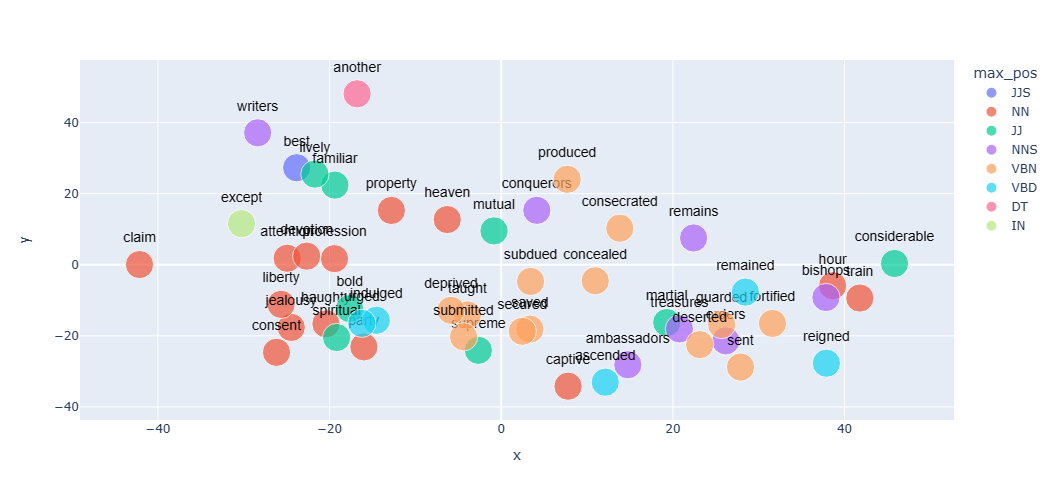

In [111]:
px.scatter(sorted_X.reset_index(), 'x', 'y', 
           text='term_str', 
           color='max_pos',        
           size='dfidf',
           height=500).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

# Riffs

Provde at least three visualizations that combine the preceding model data in interesting ways.

These should provide insight into how features in the LIB table are related. 

The nature of this relationship is left open to you -- it may be correlation, or mutual information, or something less well defined. 

In doing so, consider the following visualization types:

- Hierarchical cluster diagrams
- Heatmaps
- Scatter plots
- KDE plots
- Dispersion plots
- t-SNE plots
- etc.

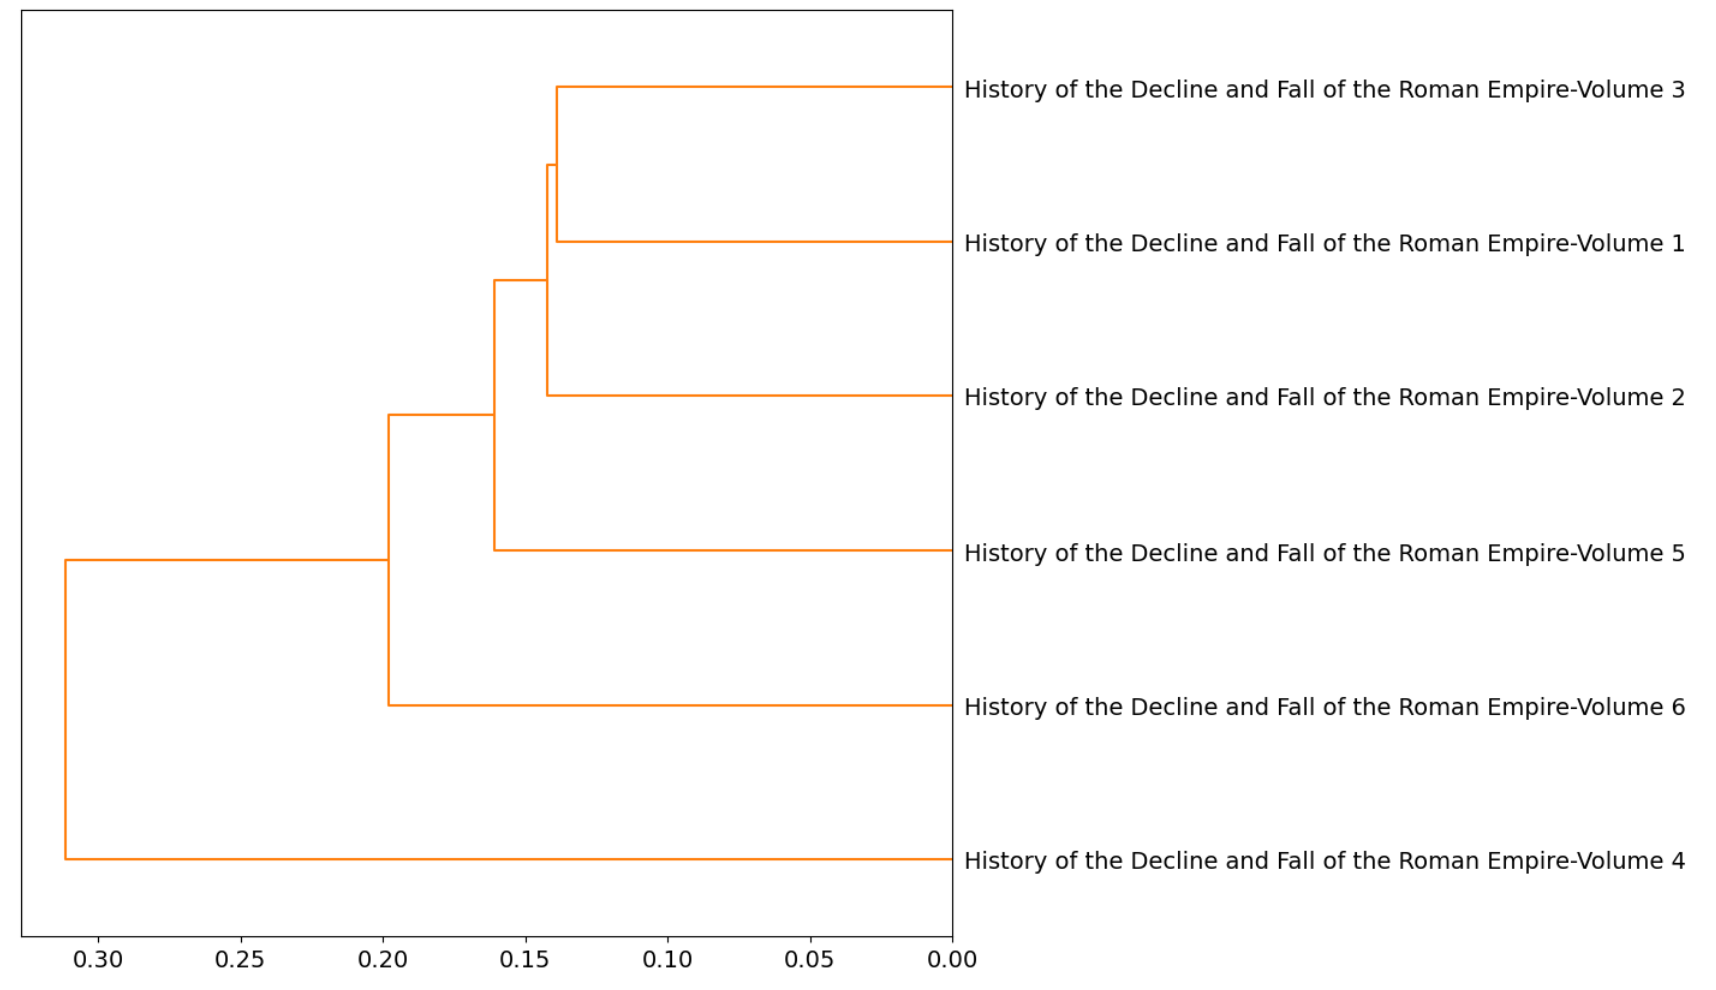

Volume 1 and Volume 3 are grouped closest together because they focus heavily on conquests and conflicts. Volume 1 focuses on conquests of Julius Caesar and the political and social climate at the time. Volume 3 focuses on conflicts pertaining to the Byzantine Empire. Volume 2 is also clustered closely to Volume 1 and Volume 3 because it thoroughly covers conflicts within the empire itself like civil wars. It makes sense that Volume 4 is separated from the other volumes because it does not actually discuss the fall of the Roman Empire, but instead focuses on the Rise of the Holy Roman Empire, the crusades and the rise of the universities and the scholastic movement. While other volumes discuss the decline of the Roman Empire and/or its provinces, Volume 4 actually discusses the emergence of a new Empire and movement. It also makes sense that Volume 6 is in an outer cluster because it does not focus on the decline and fall of the Roman Empire but more so reflects on the legacy of the empire as well as its impact on Wester Civilization.

In [113]:
# Create dataframe with cartesian product of books by books
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.index.tolist(), LIB.index.tolist()])).reset_index()

# Keep only unique pairs of different books
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])

# Name index cols
PAIRS.index.names = ['doc_a', 'doc_b']

In [114]:
TFIDF_L0 = small_TFIDF.astype('bool').astype('int') # Binary (Pseudo L)
TFIDF_L1 = small_TFIDF.apply(lambda x: x / x.sum(), 1) # Probabilistic

In [117]:
cityblock_dist = squareform(pdist(small_TFIDF, 'cityblock'))
euclidean_dist = squareform(pdist(small_TFIDF, 'euclidean'))
cosine_dist = squareform(pdist(small_TFIDF, 'cosine'))
jaccard_dist = squareform(pdist(TFIDF_L0, 'jaccard'))
dice_dist = squareform(pdist(TFIDF_L0, 'dice'))
js_dist = squareform(pdist(TFIDF_L1, 'jensenshannon'))

In [118]:
# Function to retrieve distance for a given pair from the squareform distance matrix
def get_pair_distance(idx1, idx2, distance_matrix):
    if idx1 > idx2:  
        idx1, idx2 = idx2, idx1
    return distance_matrix[idx1, idx2]

# Populate the PAIRS DataFrame with distances
for dist_name, dist_matrix in zip(['cityblock', 'euclidean', 'cosine', 'jaccard', 'dice', 'js'], 
                                  [cityblock_dist, euclidean_dist, cosine_dist, jaccard_dist, dice_dist, js_dist]):
    PAIRS[dist_name] = [get_pair_distance(LIB.index.get_loc(a), LIB.index.get_loc(b), dist_matrix) for a, b in PAIRS.index]

In [119]:
PAIRS

cityblock  euclidean    cosine   jaccard      dice        js
doc_a doc_b                                                              
735   736     2.117711   0.141365  0.195248  0.660714  0.493333  0.545695
      890     2.007695   0.119345  0.144391  0.700647  0.539228  0.535456
      891     2.123455   0.123932  0.148471  0.711811  0.552567  0.559061
      892     2.204016   0.138743  0.201566  0.690141  0.526882  0.569968
      893     2.508063   0.172419  0.328643  0.775478  0.633290  0.636781
736   890     1.855867   0.116329  0.202735  0.679510  0.514589  0.550508
      891     2.050613   0.137148  0.198485  0.707563  0.547464  0.566543
      892     1.902816   0.109840  0.203754  0.668919  0.502538  0.550770
      893     2.049996   0.114421  0.325348  0.752166  0.602778  0.619511
890   891     1.944402   0.114673  0.141138  0.718696  0.560910  0.546738
      892     1.750018   0.099112  0.138798  0.665505  0.498695  0.530186
      893     2.080243   0.138427  0.304491  0.733212  0.578797  0.599403
891   892     1.904671   0.115910  0.143182  0.674024  0.508323  0.524123
      893     2.144651   0.153578  0.254786  0.731317  0.576438  0.590055
892   893     2.032821   0.120381  0.251582  0.720280  0.562842  0.581806

In [125]:
def hac(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):

    # Generate the clustering
    tree = sch.linkage(sims, method=linkage_method)
    
    # Get labels for the leaves
    labels = LIB.title.values
    
    # Create a figure 
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    
    # Create a dendrogram with the tree
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    
    # Change the appearance of ticks, tick labels, and gridlines
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 640x480 with 0 Axes>

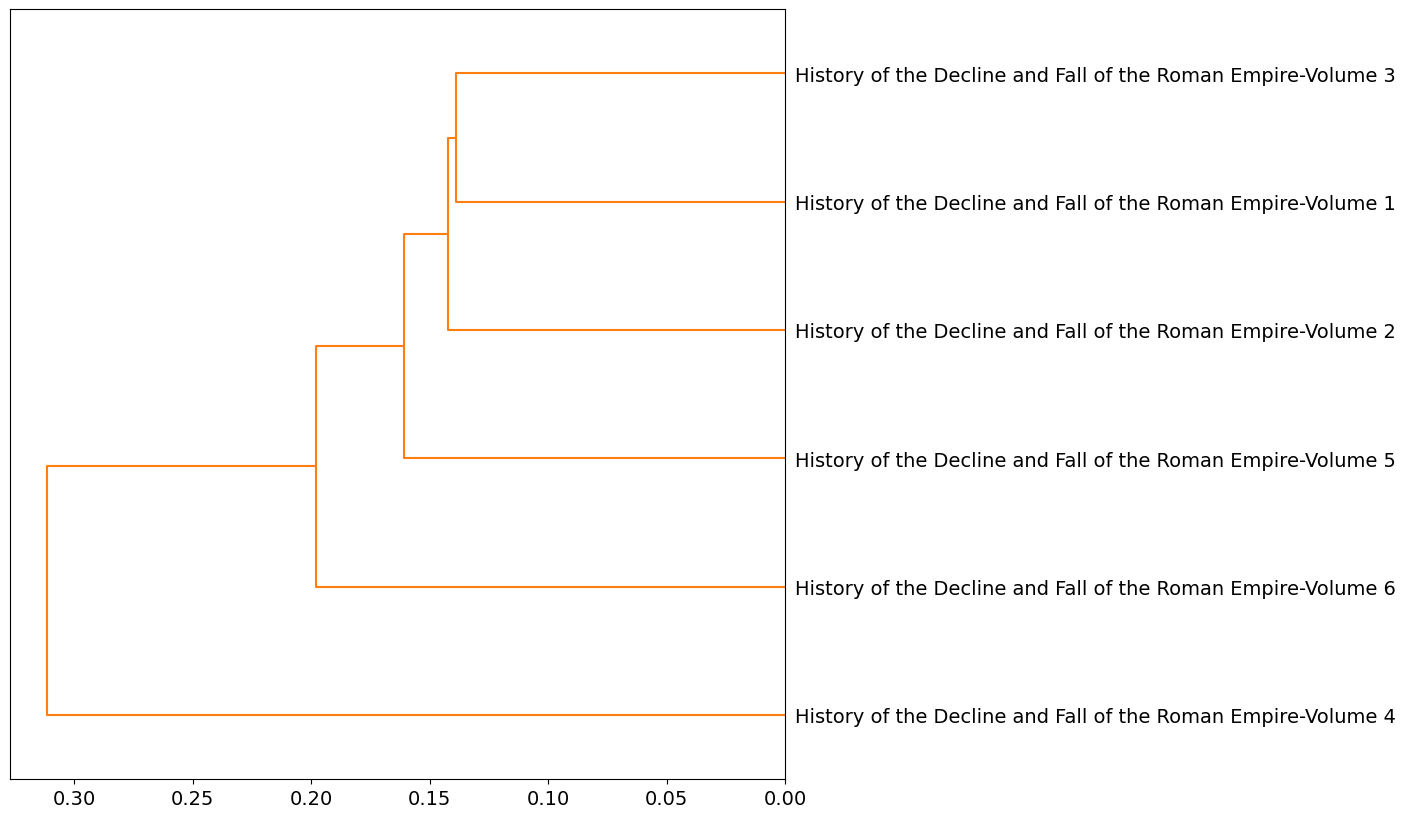

In [128]:
hac(PAIRS.cosine, linkage_method='weighted', color_thresh=1.2)

## Riff 2 (5)

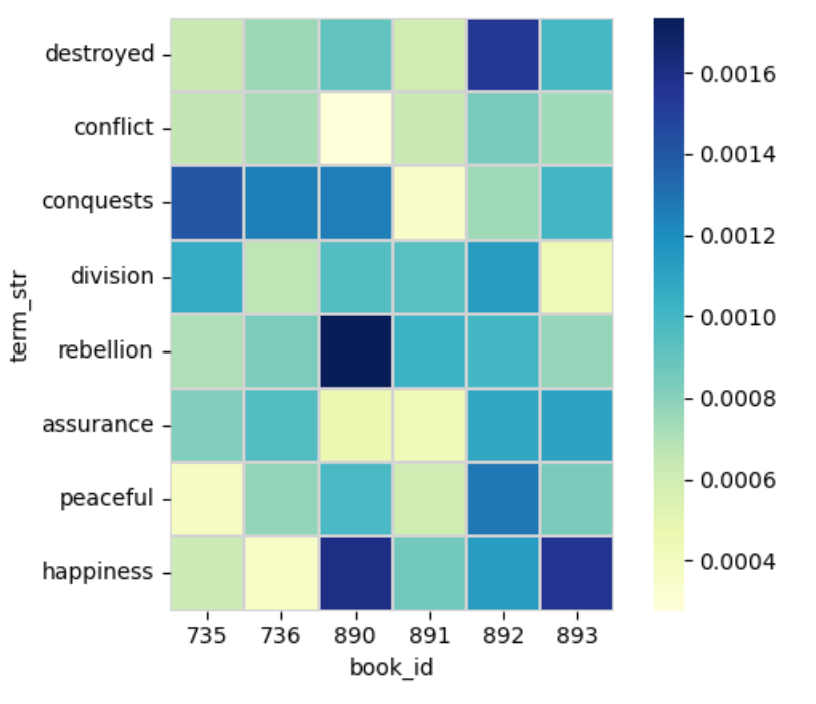

To avoid confusion book_ids 735 and 736 represent Volume 5 and Volume 6 respectively, and the book_ids in the 890s are volumes 1 through 4 in order. I chose many negative words toward the top of the list and more positive words towards the bottom. In terms of the negative words, "destroyed" stood out to me because it is very dense for Volume 3. This is most likely because it disucsses the fall of the Western Roman Empire. In terms of some of the positive words like "peaceful" and "happiness", they are mostly prevelant in the first four volumes and then very limited in the last two volumes. This more or less makes sense because Valume 5 is about the final decline of the Byzantine Empire, and Volume 6 is different from the other volumes in that it is more abstract and discusses the legacy and impacts of the Roman Empire. The word, "conquests" stood out to me because although I viewed the word with a negative connotation, in retrospect it is rather ambiguous. The word has high densities in volumes 1, 5 and 6. In the perspective of the Roman Empire, I would assume the word is positive in Volume 1 since it discusses the conquests of Julius Caesar, meanwhile it is negative in Volume 5 as it discusses the conquests of the Ottoman Empire across Europe. 

In [209]:
col_names = TFIDF_L1.columns

<Axes: xlabel='book_id', ylabel='term_str'>

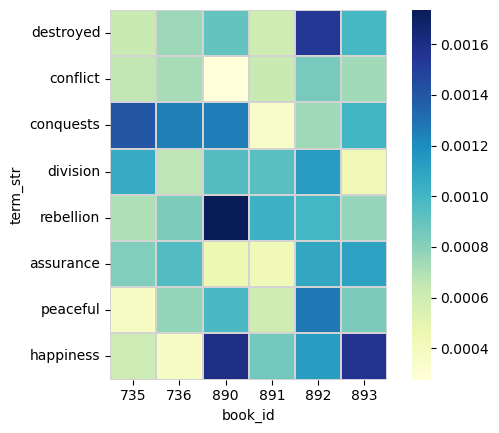

In [226]:
word_list_pos_neg = "destroyed conflict conquests division rebellion assurance peaceful happiness".split()

sns.heatmap(TFIDF_L1.groupby('book_id').mean()[word_list_pos_neg].T, cmap=colors, linewidth=.01, linecolor="lightgray", square=True)

## Riff 3 (5)

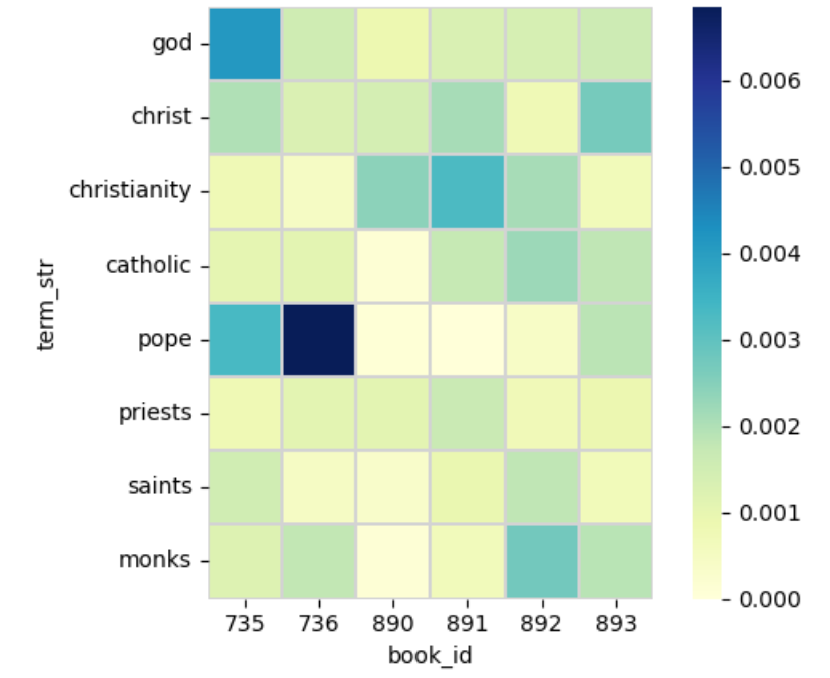

To avoid confusion book_ids 735 and 736 represent Volume 5 and Volume 6 respectively, and the book_ids in the 890s are volumes 1 through 4 in order. I created this heat map with all the words associated with religion in my reduced TFIDF to see the prevelance of religion throughout the volumes. I also wanted to add "islam", however it is not in my reduced TFIDF. In terms of religion, it seems the first three volumes mention "christianity" often and then that fades in the later volumes. It makes sense that Volume 2 mentions "christianity" the most because it partially focuses on the rise of Christianity. It is also interesting to see that "catholic" is mentioned the most Volume 4, which is makes sense because Volume 4 focuses the rise of the Holy Roman Empire. The square that stands out the most, however, is "pope" for Volume 6. Since Volume 6 focuses on the long-term impacts of the Roman Empire, mentions of catholicism and the "pop" seems relevant.

<Axes: xlabel='book_id', ylabel='term_str'>

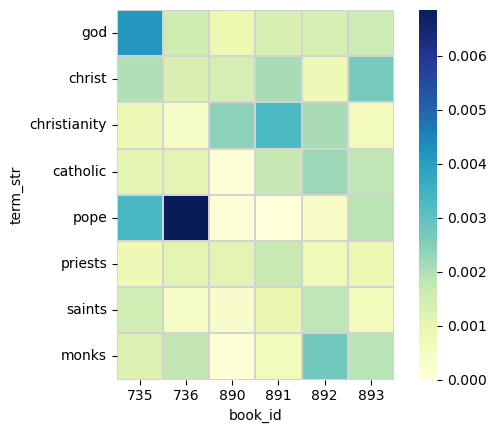

In [225]:
word_list_relig = "god christ christianity catholic pope priests saints monks".split()

sns.heatmap(TFIDF_L1.groupby('book_id').mean()[word_list_relig].T, cmap=colors, linewidth=.01, linecolor="lightgray", square=True)

# Interpretation (4)

Describe something interesting about your corpus that you discovered during the process of completing this assignment.

At a minumum, use 250 words, but you may use more. You may also add images if you'd like.

Overall, I thought the project was quite interesting and provided a lot of insights on History of the Decline and Fall of the Roman Empire by Edward Gibbon. The project also showed a lot of the similarities and differences between the six volumes whether it was through PCA, LDA, sentiment analysis, word-to-vector or the Riff vizualizations. What I thought was one of the most interesting representations was the topics table sorted by document weighted sum.

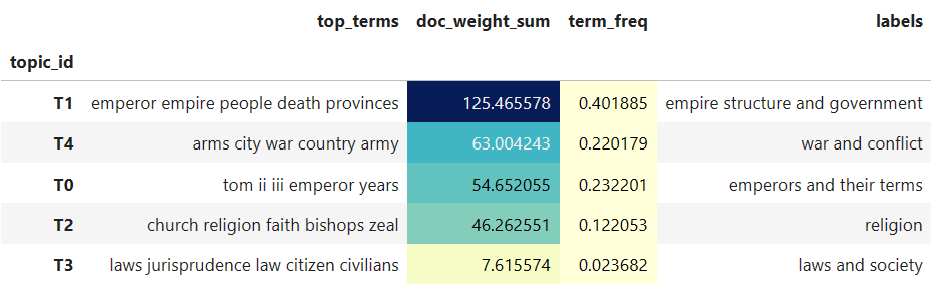

I think the visual above is an excellent representation of the most prevalent topics in the corpus, the words associated with each topic, and the emphasize on each topic throughout the corpus. Based on my interpretations of the top terms in each topic, it seems like the most frequenty discussed topic has to do with the structure and government of the empire and its provinces. It is not a surprise that this would be the most common topic throughout the Decline and Fall of the Roman Empire volumes because it provides context for all the actions of the empire and its people. The second most prevalent topic appears to do with war and conflict. Of course, the Roman Empire being the dominant force that it was in the world, was almost always at war and either conquering or conceding land. This topic is what I find the most interesting about the history of empires, so it is informative for me to see it as the second most discussed topic. The third topic on the list appears to do with specific emporers, which is also quite interesting as it can be intriguing to compare the terms of different emperors. The fourth topic refers to the history of religion in the Roman Empire. The religious significance of the Roman Empire was immense especially with the rise of the Holy Roman Empire and the Catholic Church. The last topic has to fo with Roman laws and its civilians and by observing its document weighted sum values, it is not nearly as discussed as the other topics. However, this can still be informative and provide a lot of information for those interested on learning about societies and people within the Roman Empire.

The insight provided by the topics table gives someone a general understanding of the structure of the Decline and Fall of the Roman Empire volumes and the different lenses Gibbon chooses to use throughout his narrative.